# Introduction 📒

In this project, I have explored the application of Temporal Fusion Transformer (TFT), a powerful Deep Learning architecture, to address the challenges of forecasting sales data across multiple time horizons. With a focus on accurate and reliable sales predictions, this project demonstrates my expertise in time series analysis and forecasting using state-of-the-art techniques.

# Problem Statement❓

Developing a robust sales forecasting model that accurately predicts future sales can be very challenging when it comes across different time horizons. Sales data often exhibits complex temporal patterns and dependencies influenced by various factors, such as seasonality, promotions, and market dynamics.

# Objective ✨

1. Data Preprocessing: Gather and preprocess historical sales data. Prepare the data in a TimeSeriesDataSet format in PyTorch for training the TFT model.
2. TFT Architecture: Leveraging its ability to capture long-term dependencies, model temporal interactions and incorporate its inherited attribute from Transformer models, attention-based mechanism for model training.
3. Model Interpretability and Explainability: Explore techniques to interpret and explain the TFT model's predictions, gaining insights into the factors driving sales fluctuations and patterns. This enables stakeholders to understand the rationale behind the forecasts and make informed decisions.

In [1]:
#Initialization

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from datetime import datetime
import os
#os.getcwd()

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = 'C:/Users/Weihau.yap/.spyder-py3/TFT/Walmart/features.csv'
file_path1 = 'C:/Users/Weihau.yap/.spyder-py3/TFT/Walmart/stores.csv'
file_path2 = 'C:/Users/Weihau.yap/.spyder-py3/TFT/Walmart/test.csv'
file_path3 = 'C:/Users/Weihau.yap/.spyder-py3/TFT/Walmart/train.csv'

features = pd.read_csv(file_path)
stores = pd.read_csv(file_path1)
test = pd.read_csv(file_path2)
train = pd.read_csv(file_path3)

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [3]:
features.head(5)

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [4]:
stores.head(5)

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [5]:
train.head(5)

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

In [6]:
test.head(5)

Store  Dept       Date  IsHoliday
0      1     1 2012-11-02      False
1      1     1 2012-11-09      False
2      1     1 2012-11-16      False
3      1     1 2012-11-23       True
4      1     1 2012-11-30      False

## Data Handling

In [7]:
# Number of Nans, num_sold not present in test, it's the column we have to predict

(train.isna().sum(axis = 0).rename('nans_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.isna().sum(axis = 0).rename('nans_per_column_test').rename_axis('column').reset_index().set_index('column')))

nans_per_column_train  nans_per_column_test
column                                                   
Store                             0                   0.0
Dept                              0                   0.0
Date                              0                   0.0
Weekly_Sales                      0                   NaN
IsHoliday                         0                   0.0

In [8]:
# Number of Unique values, num_sold not present in test, it's the column we have to predict

(train.nunique(axis = 0).rename('n_unique_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.nunique(axis = 0).rename('n_unique_per_column_test').rename_axis('column').reset_index().set_index('column')))

n_unique_per_column_train  n_unique_per_column_test
column                                                           
Store                                45                      45.0
Dept                                 81                      81.0
Date                                143                      39.0
Weekly_Sales                     359464                       NaN
IsHoliday                             2                       2.0

In [9]:
#Concat the store type and size
data = pd.concat([train, test], axis = 0, ignore_index=True)
data['Date'] = pd.to_datetime(data['Date'])
data.head(5)

#Merge the store type and size
df = features.merge(stores, how = 'inner', on = 'Store')
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df.Date.dt.day
df['Week'] = df.Date.dt.week
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
df.head(5)

data_merge = data.merge(df, how = 'inner', on = ['Store', 'Date', 'IsHoliday'])
data_merge.head(5)

#Data Slicing for later
train_merge = data_merge.iloc[:len(train)]
test_merge = data_merge.iloc[len(train):]

C:\Users\Weihau.yap\AppData\Local\Temp\ipykernel_27036\2928245225.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df.Date.dt.week


## Exploratory Data Analysis (EDA)

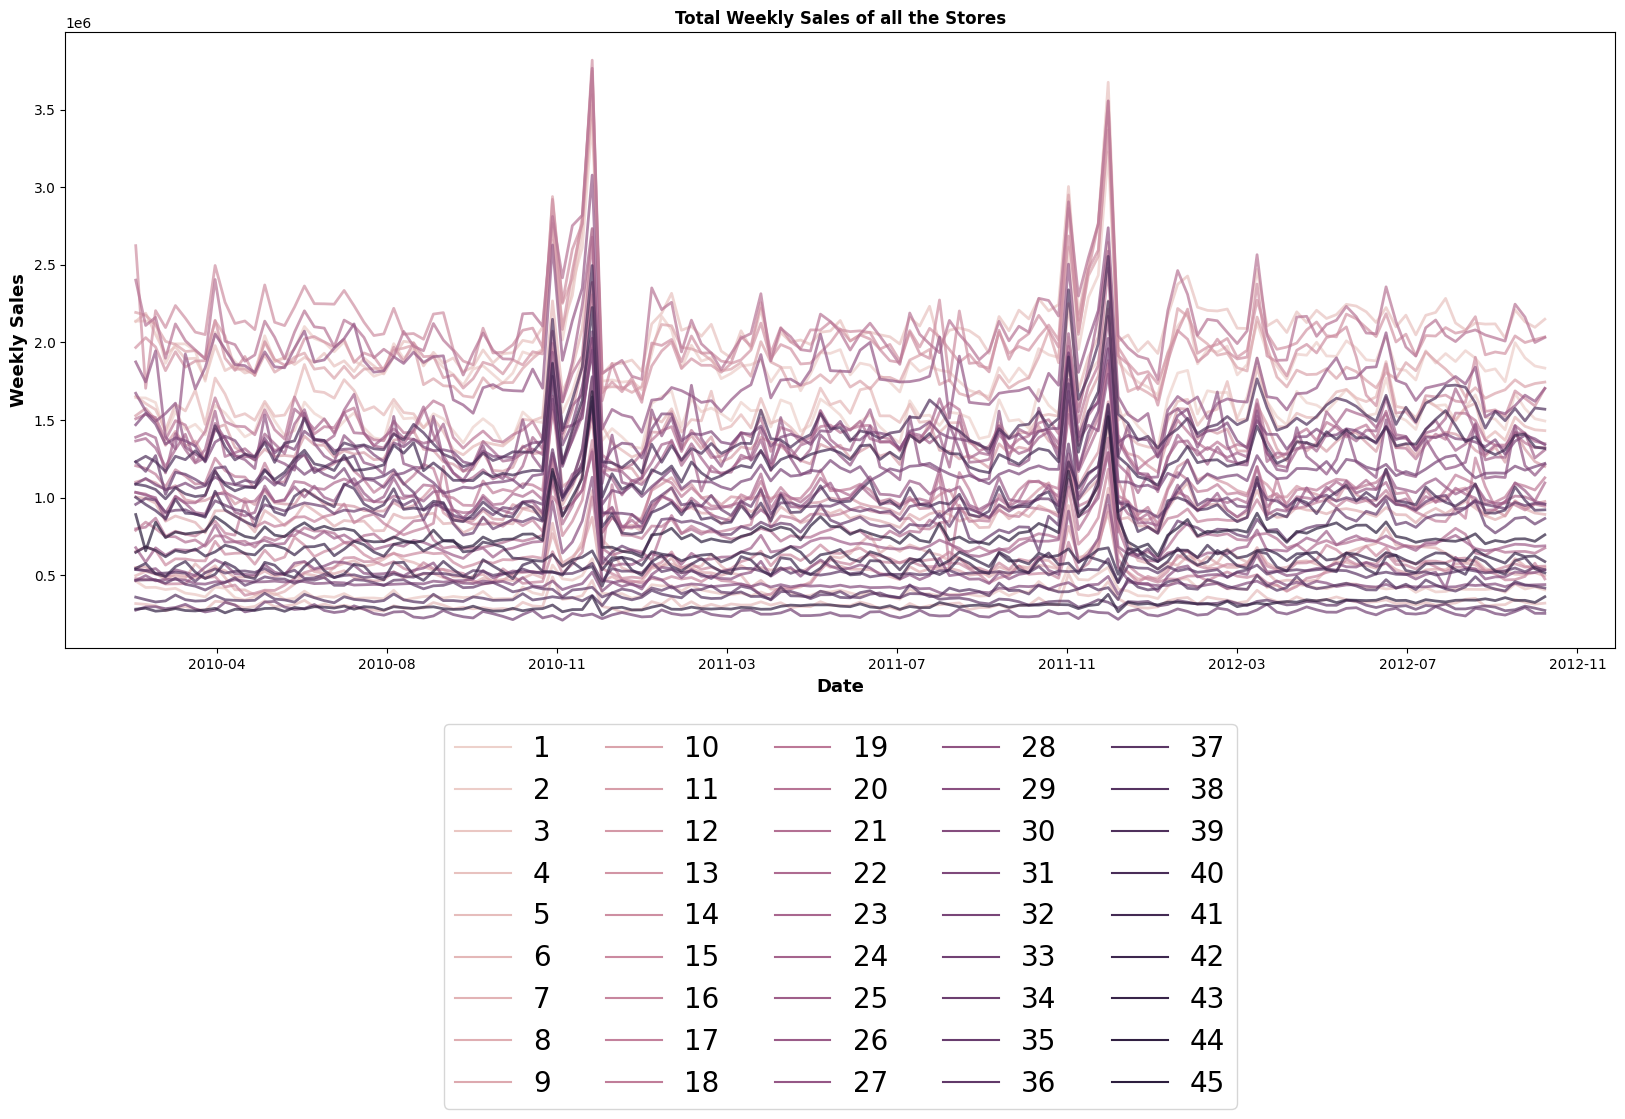

In [10]:
#Showing the trend of weekly sales for each store
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='Date',y='Weekly_Sales',hue='Store',legend='full',data=(train.groupby(['Date', 'Store']).Weekly_Sales.sum().rename('Weekly_Sales')
                                                       .reset_index().sort_values('Date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('Date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Weekly Sales', color='black', fontweight='bold', fontsize=13)
#ax.legend(fontsize = 20, loc = 'upper left')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=len(train.columns),fontsize = 20)
ax.set_title('Total Weekly Sales of all the Stores', fontweight = 'bold', fontsize = 12);

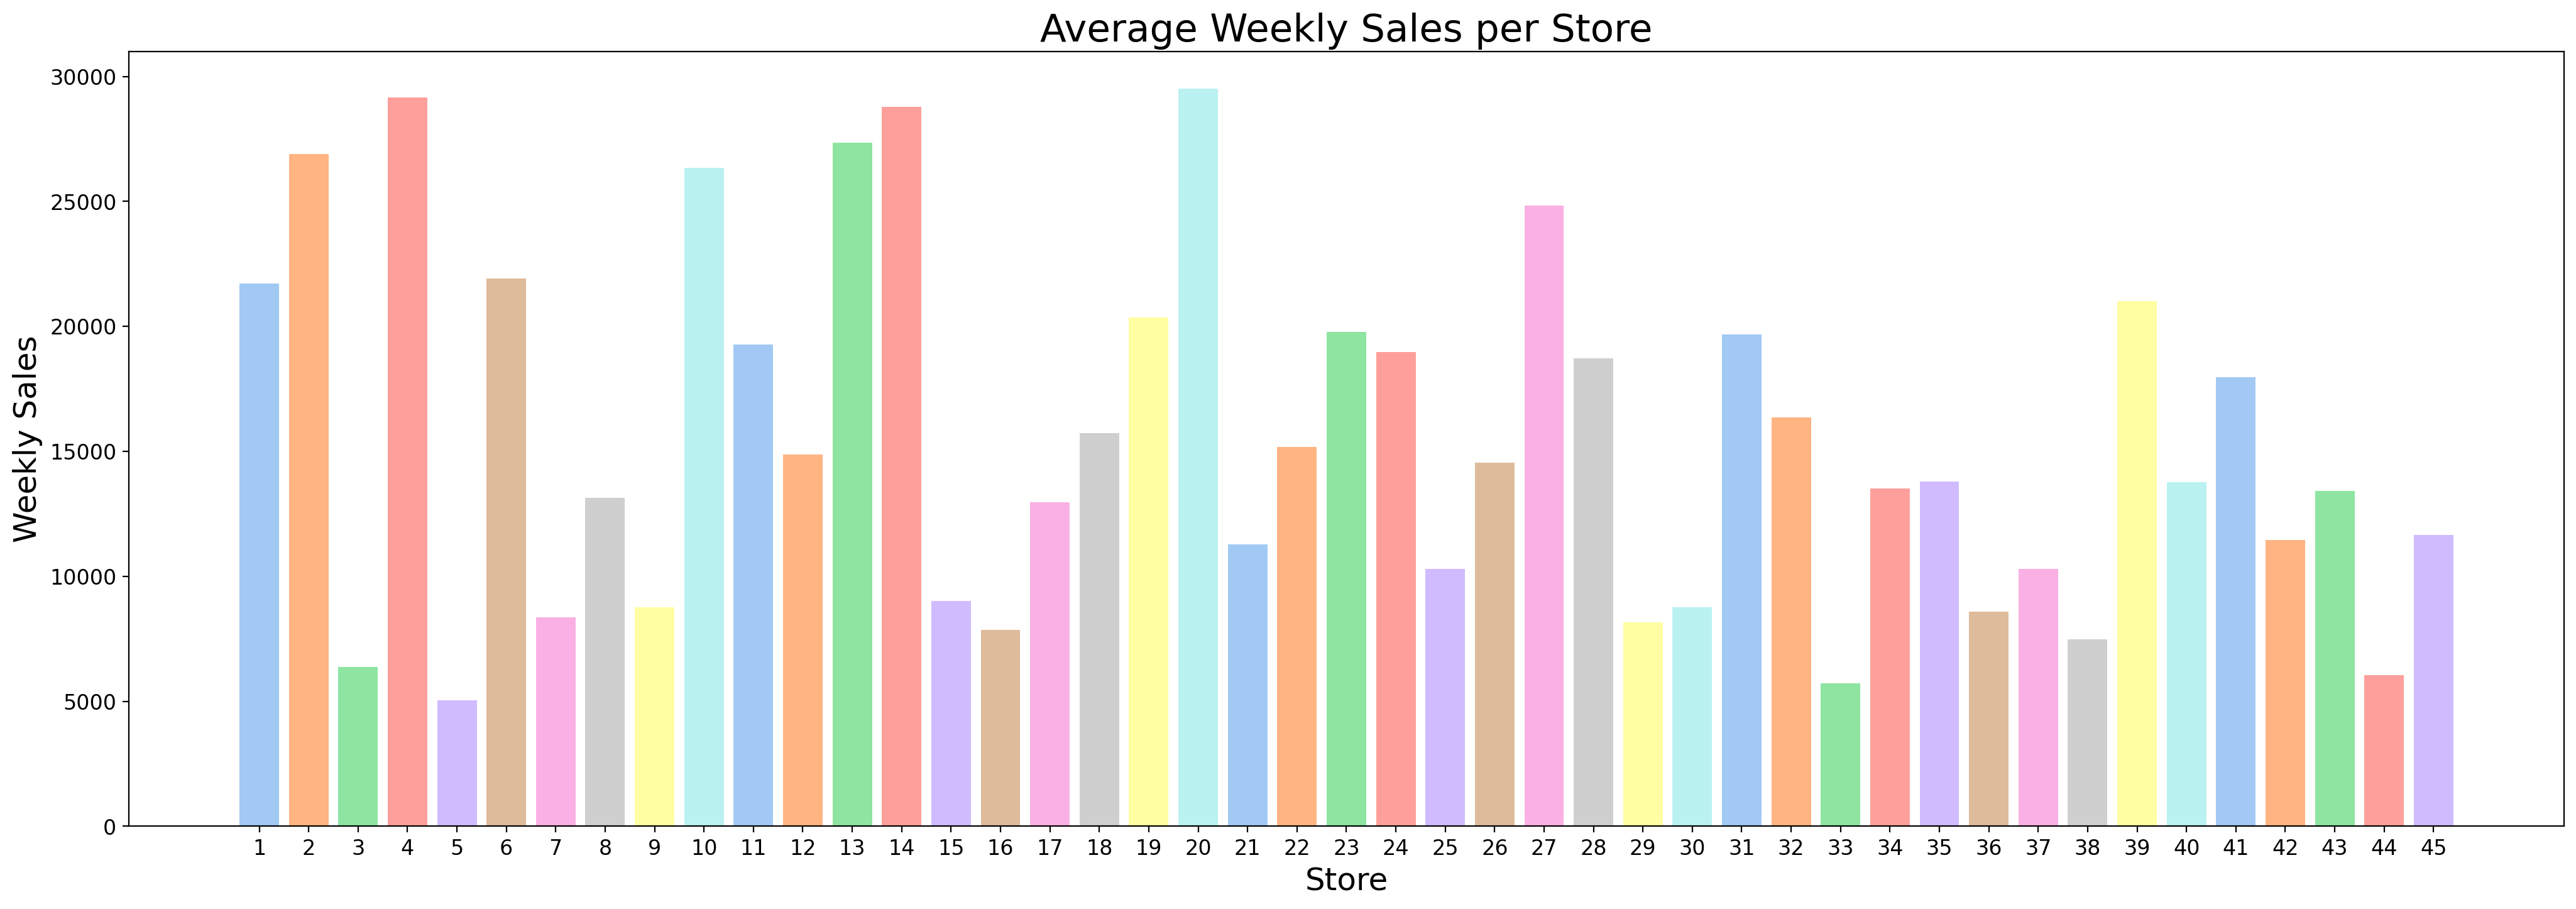

In [11]:
#Showing the average weekly sales of each store
weekly_sales_dept = train_merge['Weekly_Sales'].groupby(train_merge['Store']).mean()
x = weekly_sales_dept.index
y = weekly_sales_dept.values

plt.figure(figsize=(25, 8), dpi=200)
plt.bar(x,y,color=sns.color_palette("pastel",45))
plt.xticks(range(min(x), max(x)+1), fontsize=12)
plt.title('Average Weekly Sales per Store', fontsize=22)
plt.xlabel('Store', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

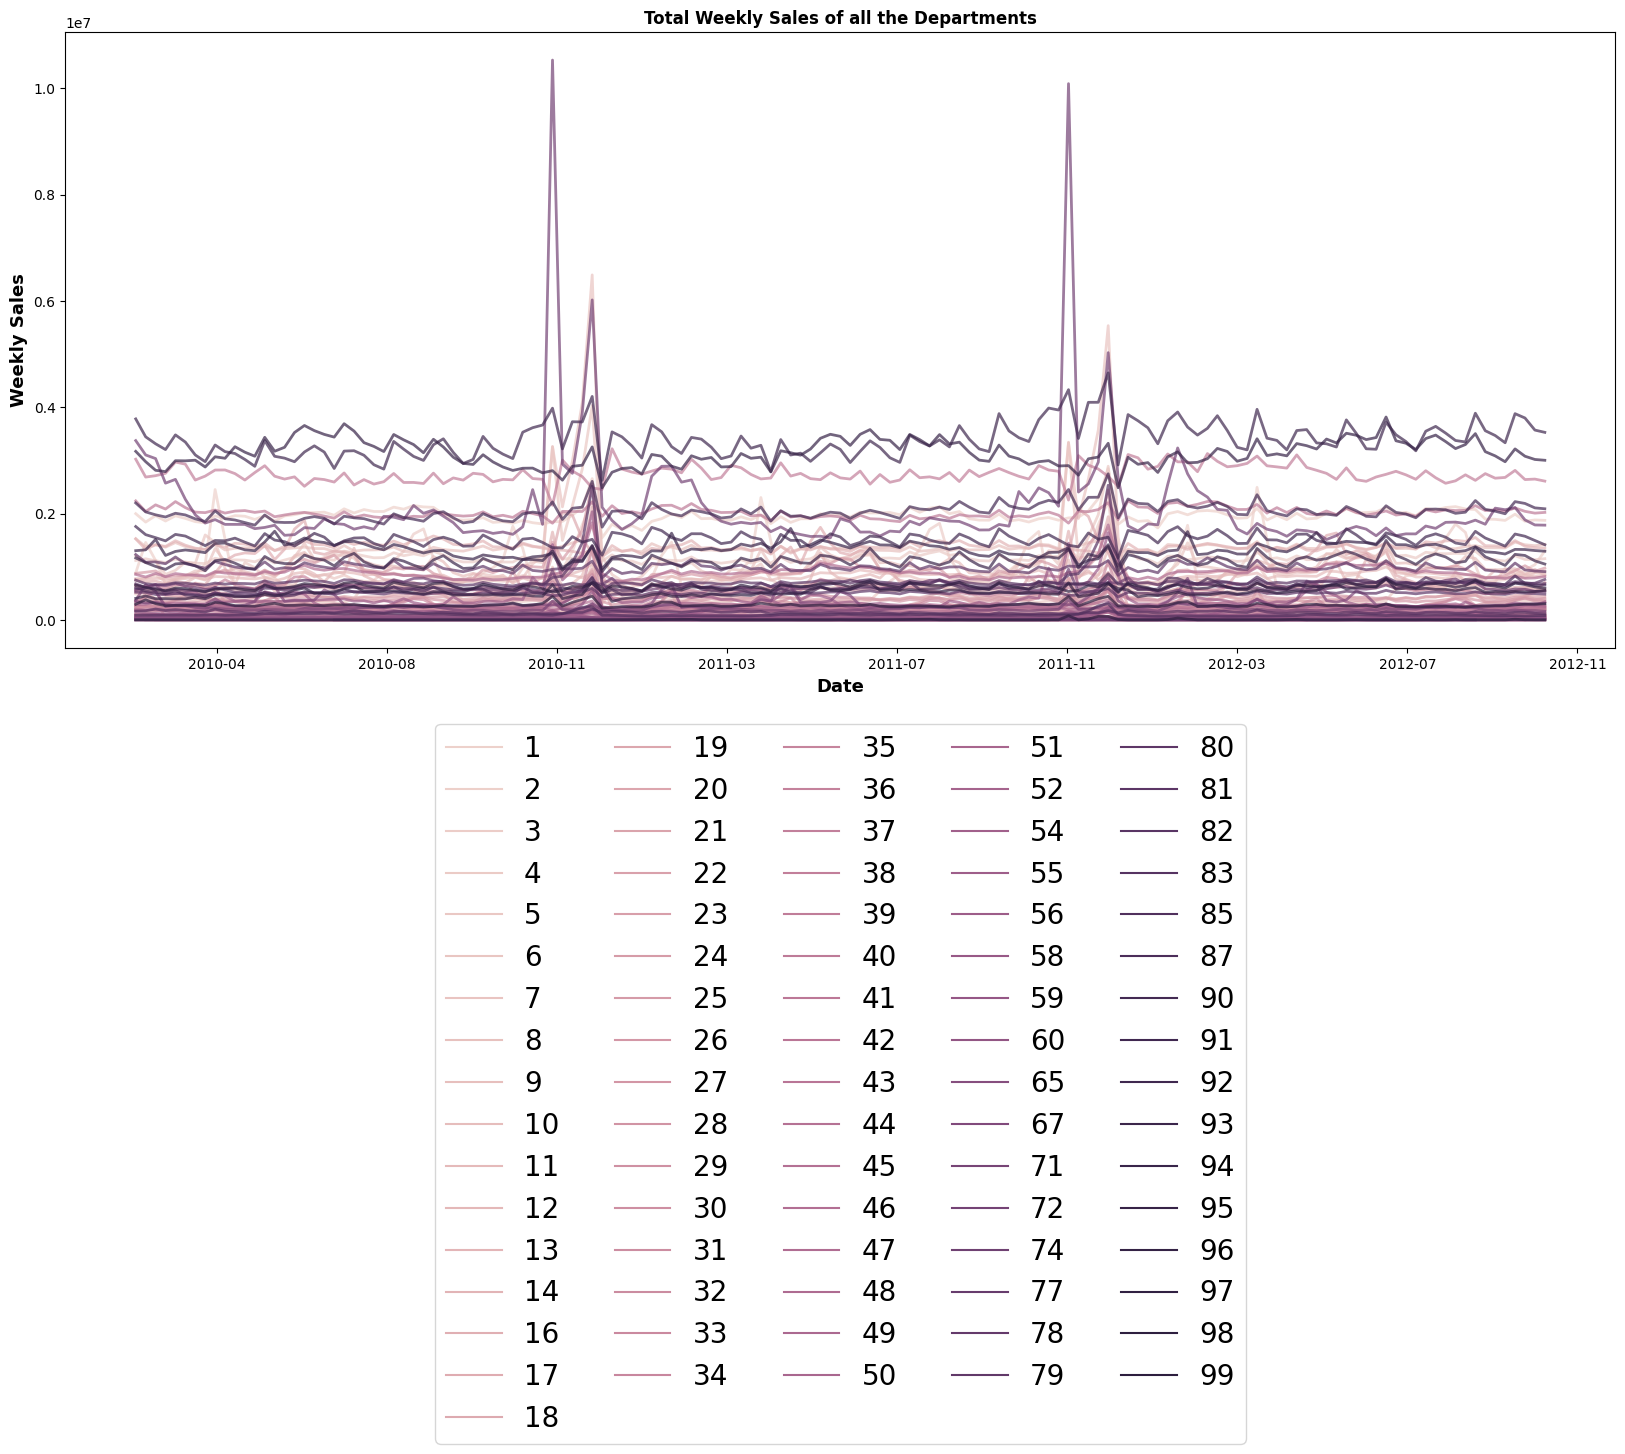

In [12]:
#Showing the trend of weekly sales for each department
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='Date',y='Weekly_Sales',hue='Dept',legend='full',data=(train.groupby(['Date', 'Dept']).Weekly_Sales.sum().rename('Weekly_Sales')
                                                       .reset_index().sort_values('Date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120)) 
ax.set_xlabel('Date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Weekly Sales', color='black', fontweight='bold', fontsize=13)
#ax.legend(fontsize = 20, loc = 'upper left')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=len(train.columns),fontsize = 20)
ax.set_title('Total Weekly Sales of all the Departments', fontweight = 'bold', fontsize = 12);

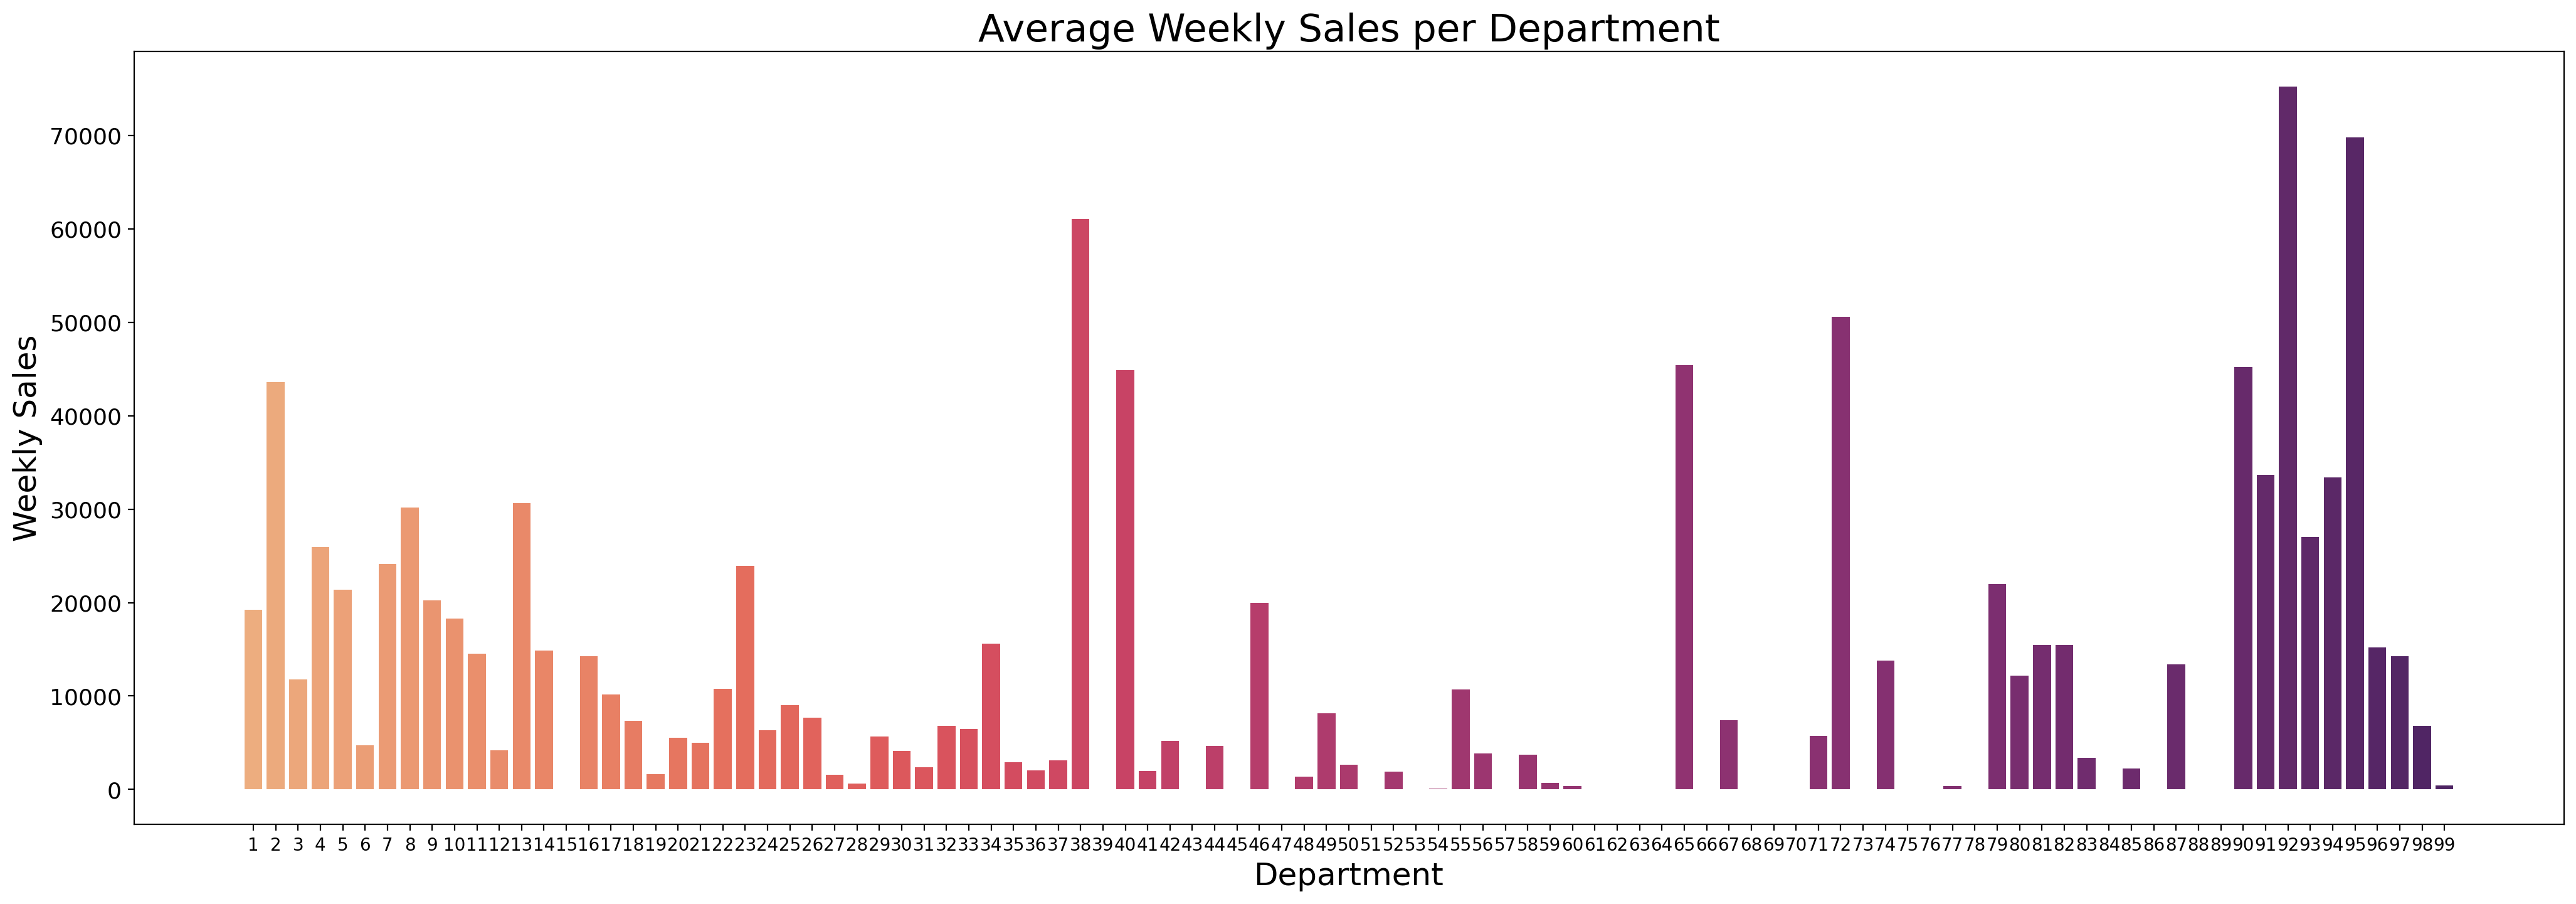

In [13]:
#Showing the average weekly sales of each department
weekly_sales_dept = train_merge['Weekly_Sales'].groupby(train_merge['Dept']).mean()
x = weekly_sales_dept.index
y = weekly_sales_dept.values

plt.figure(figsize=(25, 8), dpi=200)
plt.bar(x,y,color=sns.color_palette("flare",81))
plt.xticks(range(min(x), max(x)+1))
plt.title('Average Weekly Sales per Department', fontsize=22)
plt.xlabel('Department', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=18)
plt.yticks(fontsize=13)
plt.show()

In [14]:
print(train.shape)
print(test.shape)
print(data.shape)
print(features.shape)
print(stores.shape)
print(df.shape)

(421570, 5)
(115064, 4)
(536634, 5)
(8190, 12)
(45, 3)
(8190, 18)


In [15]:
#Want to know the unique value of department in each store
print(data['Store'].unique())
print(data['Dept'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]


In [16]:
#Data integrity
store_dept_table = pd.pivot_table(data_merge, index='Store', columns='Dept',
                                  values='Weekly_Sales')
display(store_dept_table)

Dept             1              2             3             4             5   \
Store                                                                          
1      22513.322937   46102.090420  13150.478042  36964.154476  24257.941119   
2      30777.980769   65912.922517  17476.563357  45607.666573  30555.315315   
3       7328.621049   16841.775664   5509.300769   8434.186503  11695.366573   
4      36979.940070   93639.315385  19012.491678  56603.400140  45668.406783   
5       9774.553077   12317.953287   4101.085175   9860.806783   6699.202238   
6      23867.553776   50269.437273  16806.638811  34187.366503  34465.307622   
7       9542.801259   22603.690769   8633.536923  14950.518601  13860.350490   
8      14789.827343   35729.821748  10683.305105  21089.309301  19838.849231   
9      11846.558252   24969.477413   7497.356783  17165.947762  19282.746014   
10     39925.138951  109795.291469  32086.181469  48579.826364  58373.460280   
11     18860.911958   57114.326224  17628.778671  28837.744545  36663.363916   
12     17330.087622   74494.846224  17535.251678  26673.788182  27756.204615   
13     47020.455455   76339.960000  26116.623706  42563.275455  56786.934755   
14     30611.783357   77704.857972  19418.273986  52936.323287  33468.325035   
15     13845.747832   26317.410769  10470.811958  13082.172448  16465.706993   
16     11352.479371   23549.144965   7635.427273  14748.078112  13494.538671   
17     22801.609161   42231.844406  19278.955035  23961.357273  27082.325594   
18     21988.356224   63665.139510  16392.980490  26775.207203  22933.954965   
19     21504.029161   50841.072937  18414.224476  31365.545315  28759.223846   
20     40545.473217   78251.249930  15490.971259  51456.376643  41647.786503   
21     14950.049231   47780.599161  14607.126923  19354.728042  16090.874545   
22     21493.271119   53361.851888  13150.979510  32104.132378  23187.335105   
23     33186.460559   70522.580140  19912.564755  27324.303077  36895.869021   
24     18859.023357   40797.169301  11825.589021  29245.357552  29178.058811   
25     20145.897483   36871.310559  11788.130979  20351.455455  12422.996434   
26     19402.762937   27398.030979   7357.400769  24498.113846  17589.532587   
27     30437.976224   79001.049161  20226.734615  43596.933916  28059.038252   
28     20180.453986   57751.274336  12562.223287  27980.817203  28221.618392   
29     15504.699580   25181.662727   7995.955804  14326.216224  12931.821259   
30      9788.376643   12974.464476    739.981888  13216.100909    405.565944   
31     17356.652448   58512.131538  10616.675944  34848.899231  18715.630769   
32     22852.639510   50323.497343  15472.540140  28137.154965  20748.371888   
33      2379.086573    7471.425105    283.950140   6107.616014    112.728310   
34     19947.573077   34916.225874   8377.376434  19791.509021  21633.900559   
35     17082.647902   45578.456224  14308.382797  19495.631119  24858.433706   
36      2239.227413   13416.025664    381.324266   9873.505105    314.753982   
37     11024.235874   16511.446224   1297.862028  17614.013636   1137.631189   
38      6923.538531   10986.172657    498.700210  10669.501329    397.418322   
39     21925.021189   67338.429371  20569.701608  44807.515105  24043.436783   
40     18794.578811   26702.705175   6489.030350  24386.750559  17689.671678   
41     23205.259930   48349.828951  17021.833357  30538.574895  25513.943776   
42     10375.148392   15976.902448    814.451189  14885.264755   1052.296783   
43      7549.109021   20722.851469    999.648881  18227.382168    575.417326   
44      8049.992308    9377.273007    571.016713   7403.959580    960.670490   
45     17745.916014   35800.912448   9508.014965  24229.873147  16107.063077   

Dept             6             7             8             9             10  \
Store                                                                         
1       4801.780140  24566.487413  35718.257622  28062.052238  31033.386364   
2 

In [17]:
#Check whether the four largest holiday --> Super Bowl, Labour Day, Thanksgiving, and Christmas are included
holiday = train_merge[train_merge['IsHoliday'] == True]['Date']
print("Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13")
print("Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13")
print("Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13")
print("Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 \n")
print("Holiday available in the dataset: \n", holiday.unique())
print("\nHoliday after 7-Sep-12 are missing(23-Nov-12, 28-Dec-12, 8-Feb-13, 6-Sep-13, 29-Nov-13, 27-Dec-13)")

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 

Holiday available in the dataset: 
 ['2010-02-12T00:00:00.000000000' '2010-09-10T00:00:00.000000000'
 '2010-11-26T00:00:00.000000000' '2010-12-31T00:00:00.000000000'
 '2011-02-11T00:00:00.000000000' '2011-09-09T00:00:00.000000000'
 '2011-11-25T00:00:00.000000000' '2011-12-30T00:00:00.000000000'
 '2012-02-10T00:00:00.000000000' '2012-09-07T00:00:00.000000000']

Holiday after 7-Sep-12 are missing(23-Nov-12, 28-Dec-12, 8-Feb-13, 6-Sep-13, 29-Nov-13, 27-Dec-13)


In [18]:
#Caluclate sales during holiday
holiday_sales = train_merge[train_merge['Date'].isin(holiday)]
holiday_sales = holiday_sales.groupby('Date')['Weekly_Sales'].agg(Total_Weekly_Sales='mean').reset_index()
holiday_sales

Date  Total_Weekly_Sales
0 2010-02-12        16352.056032
1 2010-09-10        15537.758883
2 2010-11-26        22403.336705
3 2010-12-31        13738.538566
4 2011-02-11        16111.706191
5 2011-09-09        15809.069483
6 2011-11-25        22043.563476
7 2011-12-30        15332.154858
8 2012-02-10        16664.247891
9 2012-09-07        16294.692957

In [19]:
#Convert holiday dates into week form for plotting
holiday_sales = train_merge[train_merge['Date'].isin(holiday)]
holiday_sales = holiday_sales.groupby('Week')['Weekly_Sales'].agg(Total_Weekly_Sales='mean').reset_index()
holiday_sales

Week  Total_Weekly_Sales
0     6        16377.996441
1    36        15881.693339
2    47        22220.944538
3    52        14543.387158

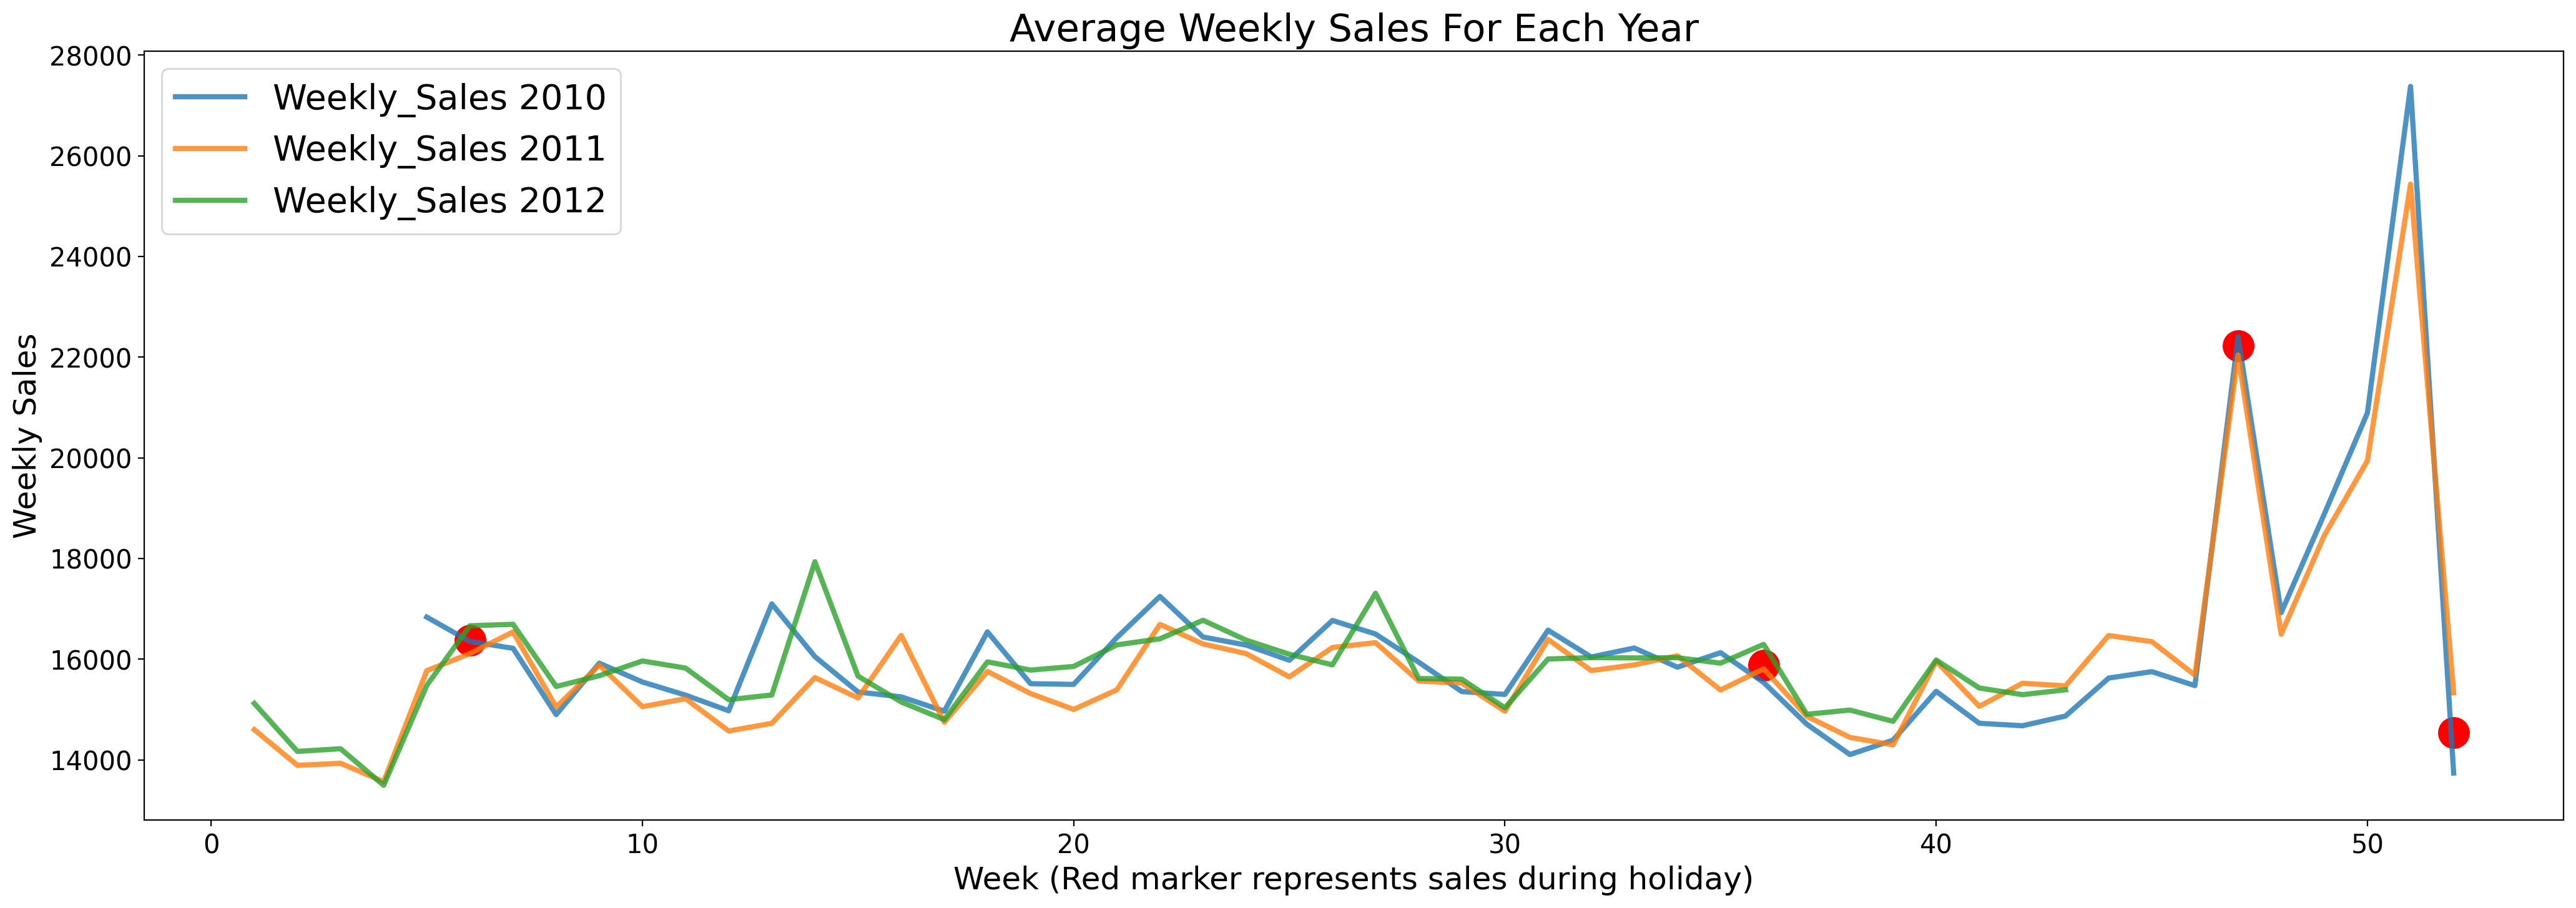

In [20]:
# Average Weekly Sales for the all 3 years
weekly_sales_2010 = train_merge[train_merge['Year']==2010]['Weekly_Sales'].groupby(train_merge['Week']).mean()
weekly_sales_2011 = train_merge[train_merge['Year']==2011]['Weekly_Sales'].groupby(train_merge['Week']).mean()
weekly_sales_2012 = train_merge[train_merge['Year']==2012]['Weekly_Sales'].groupby(train_merge['Week']).mean()

#sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values) # for plotting then lineplot
x = weekly_sales_2010.index
y = weekly_sales_2010.values
x1 = weekly_sales_2011.index
y1 = weekly_sales_2011.values
x2 = weekly_sales_2012.index
y2 = weekly_sales_2012.values

plt.figure(figsize=(25, 8), dpi=200)
plt.plot(x,y,alpha=0.8,linewidth=3,label='Weekly_Sales 2010')
plt.plot(x1,y1,alpha=0.8,linewidth=3,label='Weekly_Sales 2011')
plt.plot(x2,y2,alpha=0.8,linewidth=3,label='Weekly_Sales 2012')
plt.scatter(holiday_sales['Week'],holiday_sales['Total_Weekly_Sales'],c='red',s=300)

plt.title("Average Weekly Sales For Each Year",fontsize=22)
plt.xlabel("Week (Red marker represents sales during holiday)",fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel("Weekly Sales",fontsize=18)
plt.yticks(fontsize=15)
#plt.axhline(y=1000.0, color='r', linestyle='--', linewidth=3)
plt.legend(prop={'size': 20})
plt.show()

## Data Manipulation

In [21]:
train1 = train.groupby(['Date','Store'])['Weekly_Sales'].agg(Total_Weekly_Sales='sum').reset_index()
train1[train1['Store']==1].head(5)

Date  Store  Total_Weekly_Sales
0   2010-02-05      1          1643690.90
45  2010-02-12      1          1641957.44
90  2010-02-19      1          1611968.17
135 2010-02-26      1          1409727.59
180 2010-03-05      1          1554806.68

In [22]:
train_merge1 = train1.merge(df, how = 'inner', on = ['Date','Store'])
train_merge1.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], inplace=True)
train_merge1 = train_merge1.fillna(0)
train_merge1.head(5)

Date  Store  Total_Weekly_Sales  Temperature  Fuel_Price         CPI  \
0 2010-02-05      1          1643690.90        42.31       2.572  211.096358   
1 2010-02-05      2          2136989.46        40.19       2.572  210.752605   
2 2010-02-05      3           461622.22        45.71       2.572  214.424881   
3 2010-02-05      4          2135143.87        43.76       2.598  126.442065   
4 2010-02-05      5           317173.10        39.70       2.572  211.653972   

   Unemployment  IsHoliday Type    Size  Day  Week  Month  Year  
0         8.106      False    A  151315    5     5      2  2010  
1         8.324      False    A  202307    5     5      2  2010  
2         7.368      False    B   37392    5     5      2  2010  
3         8.623      False    A  205863    5     5      2  2010  
4         6.566      False    B   34875    5     5      2  2010

In [23]:
train_merge1.isna().sum(axis = 0).rename('nans_per_column_train').rename_axis('column').reset_index().set_index('column')

nans_per_column_train
column                                   
Date                                    0
Store                                   0
Total_Weekly_Sales                      0
Temperature                             0
Fuel_Price                              0
CPI                                     0
Unemployment                            0
IsHoliday                               0
Type                                    0
Size                                    0
Day                                     0
Week                                    0
Month                                   0
Year                                    0

In [24]:
#Data Manipulation
train_merge1 = (train_merge1.merge((train_merge1[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date']))
train_merge1['Store'] = train_merge1['Store'].astype('string').astype("category")
train_merge1['Type'] = train_merge1['Type'].astype('string').astype("category")
train_merge1['Size'] = train_merge1['Size'].astype('string').astype("category")
#train_merge1['Date'] = train_merge1['Date'].astype('string').astype("category")
train_merge1['IsHoliday'] = train_merge1['IsHoliday'].astype('string').astype("category")
train_merge1['Day'] = train_merge1['Day'].astype('string').astype("category")
train_merge1['Week'] = train_merge1['Week'].astype('int')
train_merge1['Month'] = train_merge1['Month'].astype('string').astype("category")
train_merge1['Year'] = train_merge1['Year'].astype('string').astype("category")
train_merge1['Log_Weekly_Sales'] = np.log(train_merge1['Total_Weekly_Sales'] + 1e-8)
train_merge1["Avg_Volume_By_Store"] = train_merge1.groupby(["Week", "Store"], observed=True).Total_Weekly_Sales.transform("mean")
train_merge1["Avg_Volume_By_Type"] = train_merge1.groupby(["Week", "Type"], observed=True).Total_Weekly_Sales.transform("mean")
train_merge1["Avg_Volume_By_Size"] = train_merge1.groupby(["Week", "Size"], observed=True).Total_Weekly_Sales.transform("mean")
train_merge1.sample(5)

Date Store  Total_Weekly_Sales  Temperature  Fuel_Price  \
932  2010-06-25    33           259419.91        93.66       3.084   
6347 2012-10-19     3           424513.08        73.44       3.594   
5194 2012-04-20    20          1884427.84        60.11       4.027   
2042 2010-12-17    18          1588430.71        27.40       3.139   
1928 2010-11-26    39          2149355.20        67.75       2.735   

             CPI  Unemployment IsHoliday Type    Size Day  Week Month  Year  \
932   126.126600         9.849     False    A   39690  25    25     6  2010   
6347  226.968844         6.034     False    B   37392  19    42    10  2012   
5194  214.367504         7.139     False    A  203742  20    16     4  2012   
2042  132.680452         9.331     False    B  120653  17    50    12  2010   
1928  210.515276         8.476      True    A  184109  26    47    11  2010   

      time_idx  Log_Weekly_Sales  Avg_Volume_By_Store  Avg_Volume_By_Type  \
932         20         12.466203         2.531732e+05        1.352740e+06   
6347       141         12.958698         3.894618e+05        7.766354e+05   
5194       115         14.449135         2.025717e+06        1.344386e+06   
2042        45         14.278257         1.552677e+06        1.140511e+06   
1928        42         14.580678         2.244094e+06        1.894801e+06   

      Avg_Volume_By_Size  
932         3.741915e+05  
6347        3.894618e+05  
5194        2.025717e+06  
2042        1.552677e+06  
1928        2.244094e+06

In [25]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize 'Avg_Volume_By_Type' and 'Avg_Volume_By_Size'
#train_merge1[['Total_Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Avg_Volume_By_Store','Avg_Volume_By_Type', 'Avg_Volume_By_Size']] = scaler.fit_transform(train_merge1[['Total_Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Avg_Volume_By_Store','Avg_Volume_By_Type', 'Avg_Volume_By_Size']])
train_merge1[['Total_Weekly_Sales']] = scaler.fit_transform(train_merge1[['Total_Weekly_Sales']])

In [26]:
train_merge1.head()

Date Store  Total_Weekly_Sales  Temperature  Fuel_Price         CPI  \
0 2010-02-05     1            0.397291        42.31       2.572  211.096358   
1 2010-02-05     2            0.533988        40.19       2.572  210.752605   
2 2010-02-05     3            0.069730        45.71       2.572  214.424881   
3 2010-02-05     4            0.533477        43.76       2.598  126.442065   
4 2010-02-05     5            0.029702        39.70       2.572  211.653972   

   Unemployment IsHoliday Type    Size Day  Week Month  Year  time_idx  \
0         8.106     False    A  151315   5     5     2  2010         0   
1         8.324     False    A  202307   5     5     2  2010         0   
2         7.368     False    B   37392   5     5     2  2010         0   
3         8.623     False    A  205863   5     5     2  2010         0   
4         6.566     False    B   34875   5     5     2  2010         0   

   Log_Weekly_Sales  Avg_Volume_By_Store  Avg_Volume_By_Type  \
0         14.312455         1.628887e+06        1.393418e+06   
1         14.574909         2.000545e+06        1.393418e+06   
2         13.042502         4.416998e+05        8.076951e+05   
3         14.574045         2.142535e+06        1.393418e+06   
4         12.667203         3.269114e+05        8.076951e+05   

   Avg_Volume_By_Size  
0        1.628887e+06  
1        2.000545e+06  
2        4.416998e+05  
3        2.142535e+06  
4        3.269114e+05

## Data Preparation

In [27]:
#After EDA, let's create dataloaders
#Take note that the granularity is in week

#Look back window of 6 weeks for 1 week ahead prediction
max_prediction_length = 1 * 7
max_encoder_length = 6 * 7
#Validate on last week
training_cutoff = train_merge1["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train_merge1[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Total_Weekly_Sales",
    group_ids=["Store","Type","Size"],
    min_encoder_length=max_encoder_length, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Store","Type","Size"],
    time_varying_known_categoricals=["IsHoliday","Day","Month","Year"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['Total_Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Log_Weekly_Sales',
                               'Avg_Volume_By_Store','Avg_Volume_By_Type','Avg_Volume_By_Size'],
    target_normalizer=GroupNormalizer(
        groups=["Store","Type","Size"], transformation="softplus"
    ),  # we normalize by group
    categorical_encoders = {"IsHoliday": NaNLabelEncoder(add_nan=True),
                            "Day": NaNLabelEncoder(add_nan=True),
                            "Month": NaNLabelEncoder(add_nan=True),
                            "Year": NaNLabelEncoder(add_nan=True),},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train_merge1, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [28]:
training.index.head(5)

time_first  time_last  time_diff_to_next  index_start  time  count  \
0           0        135                  1            0     0    136   
1           0        135                  1            1     1    136   
2           0        135                  1            2     2    136   
3           0        135                  1            3     3    136   
4           0        135                  1            4     4    136   

   sequence_id  index_end  sequence_length  
0            0         48               49  
1            0         49               49  
2            0         50               49  
3            0         51               49  
4            0         52               49

In [29]:
validation.index.head(5)

time_first  time_last  time_diff_to_next  index_start  time  count  \
4230           0        142                  1           94    94    143   
4239           0        142                  1          237    94    143   
4240           0        142                  1          380    94    143   
4241           0        142                  1          523    94    143   
4242           0        142                  1          666    94    143   

      sequence_id  index_end  sequence_length  
4230            0        142               49  
4239            1        285               49  
4240            2        428               49  
4241            3        571               49  
4242            4        714               49

## Build TFT model

In [30]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [31]:
torch.cuda.is_available()

True

In [32]:
torch.cuda.current_device()

0

In [33]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

In [34]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.6 K 
3  | prescalers                         | ModuleDict                      | 4.5 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 315 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 212 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.008


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.008. Signaling Trainer to stop.


In [35]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs\lightning_logs\version_75\checkpoints\epoch=9-step=700.ckpt


C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


## Evaluate on validation data and plot results

In [36]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
#print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
#print((actuals - predictions).abs().mean(axis=1))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


('output', 'x', 'index', 'decoder_lengths', 'y')


C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:1016: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


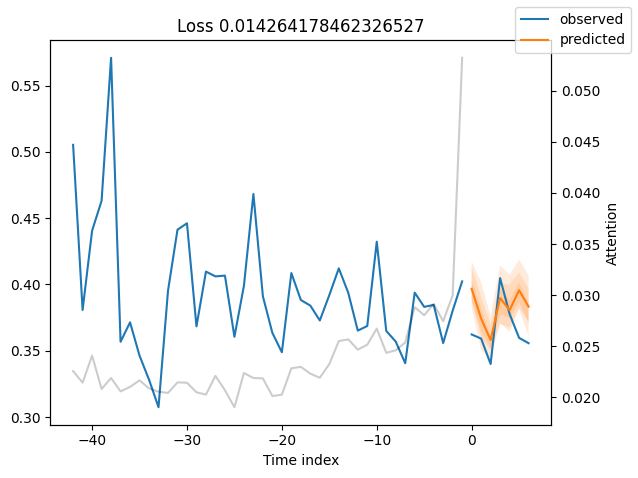

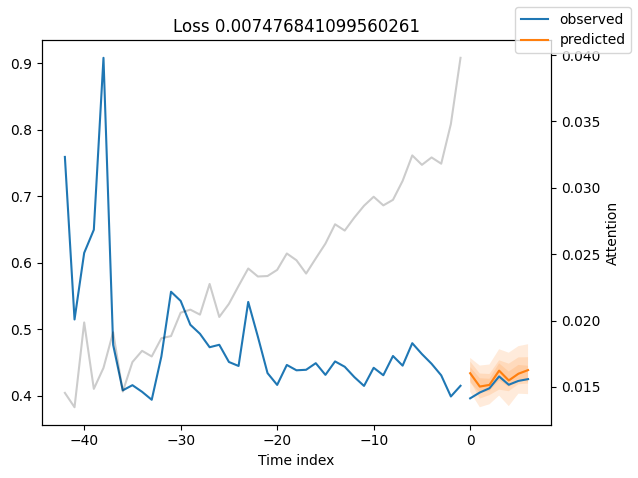

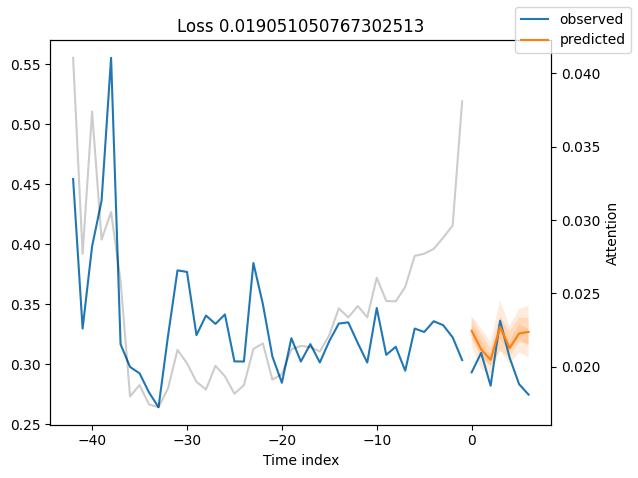

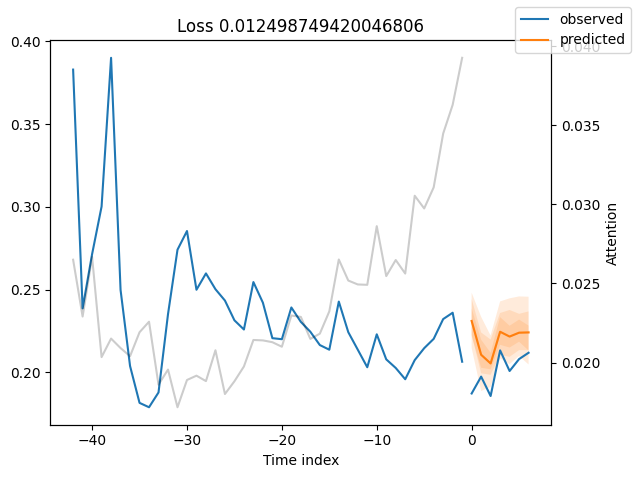

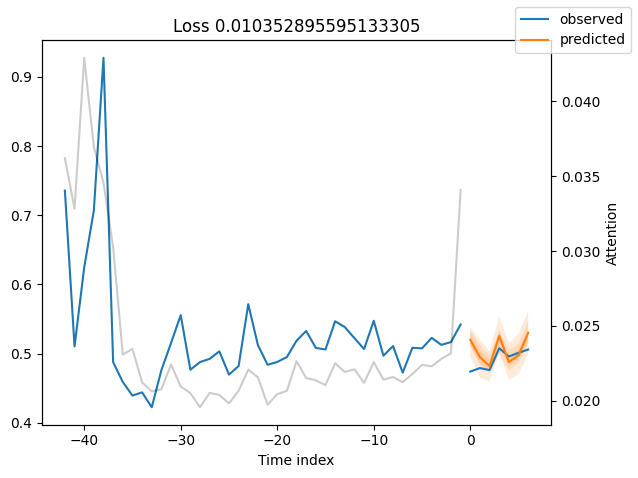

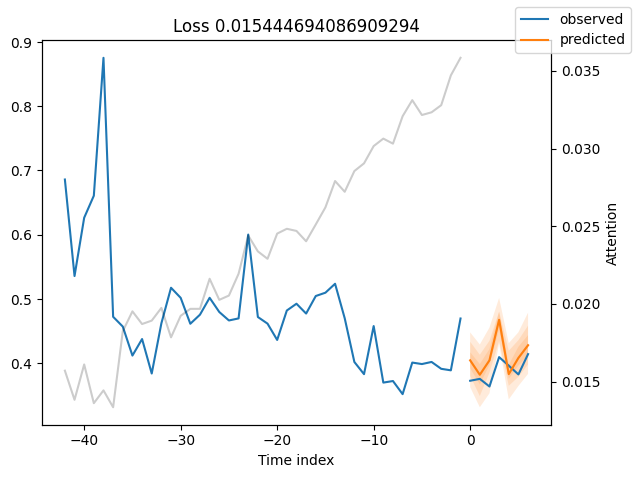

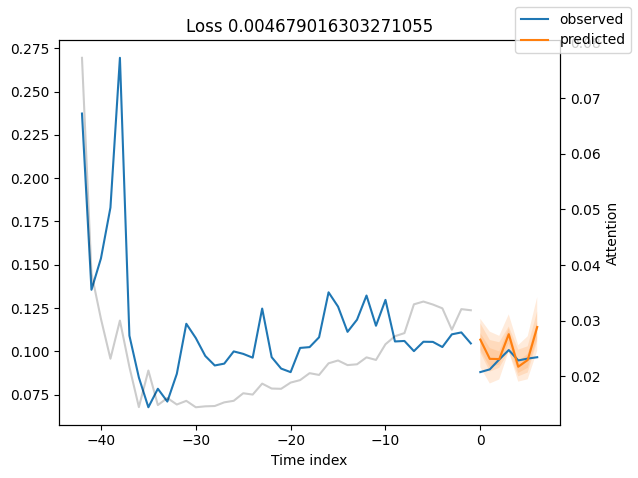

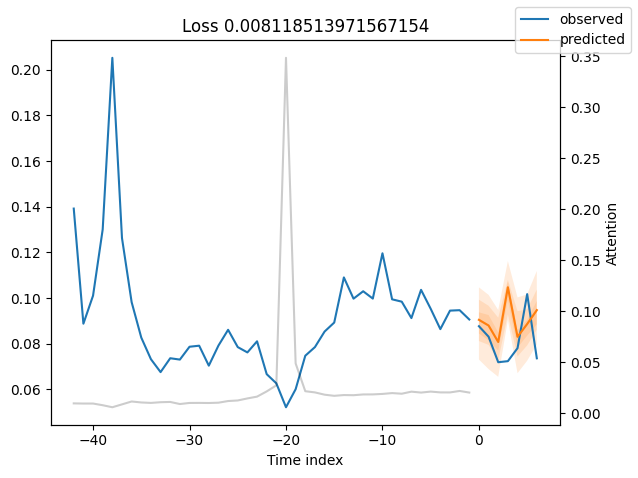

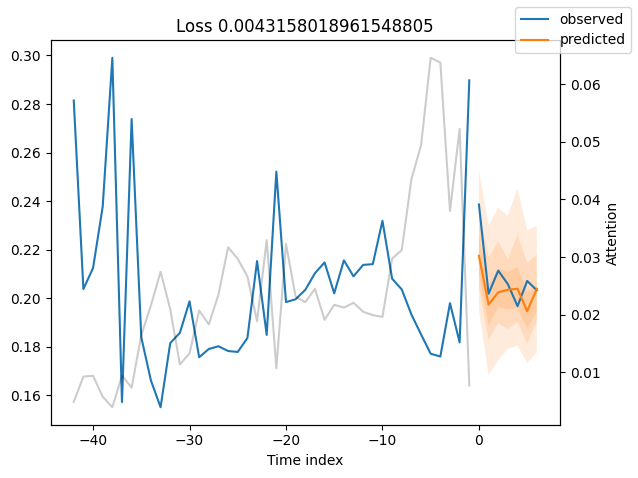

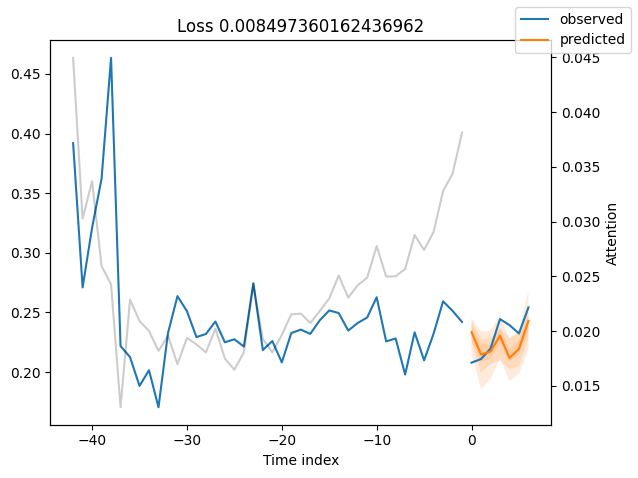

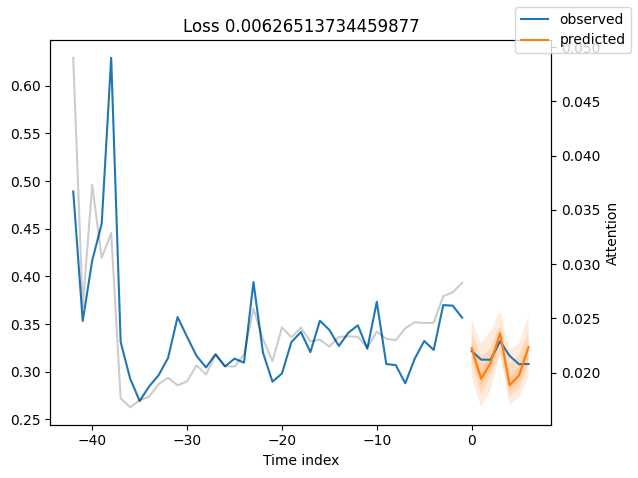

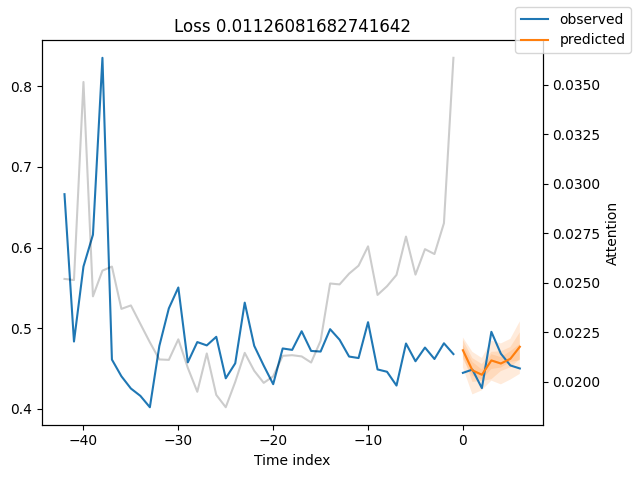

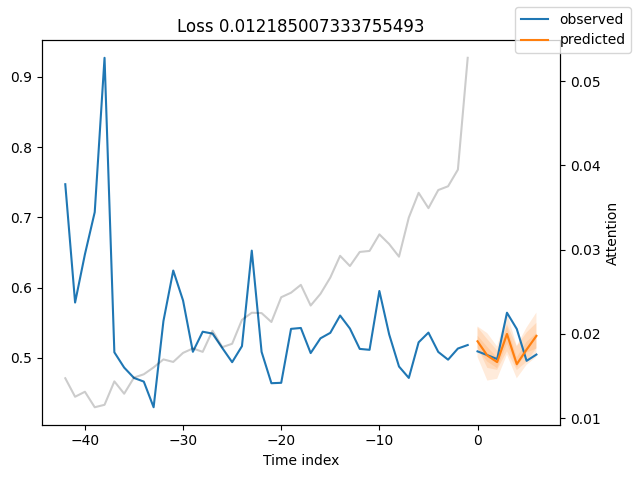

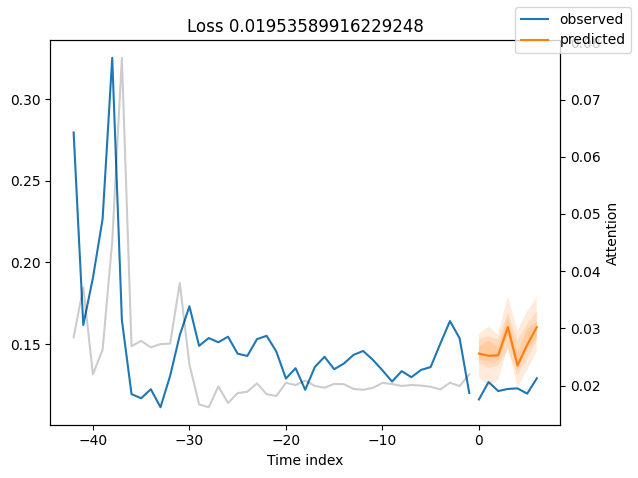

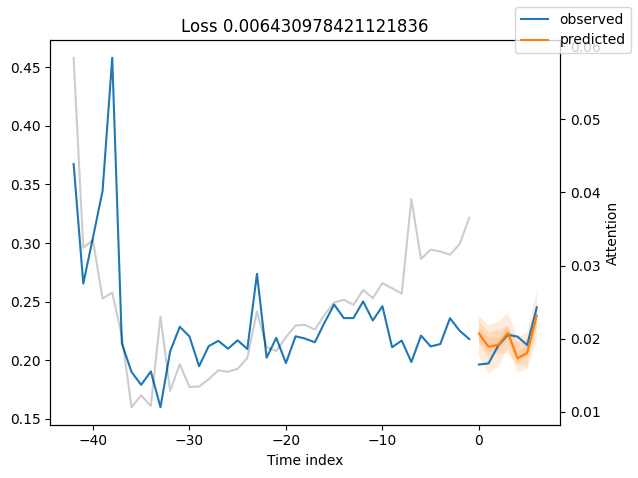

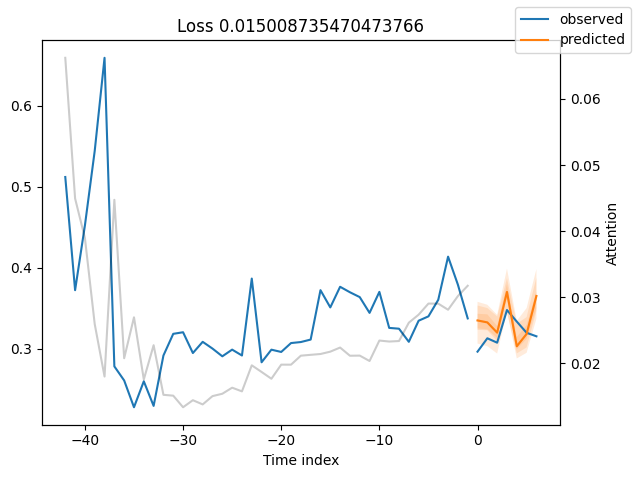

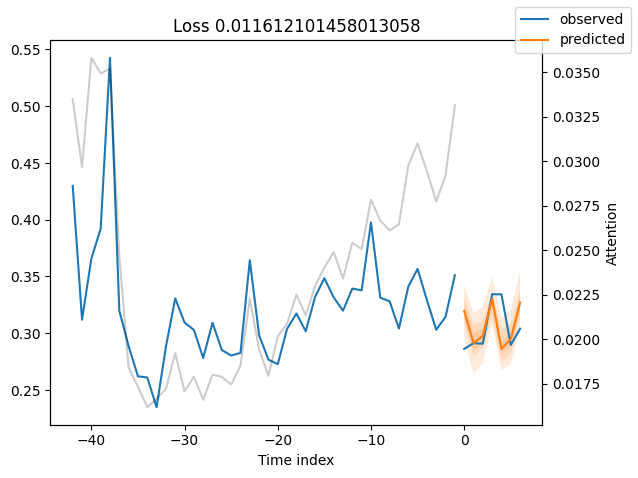

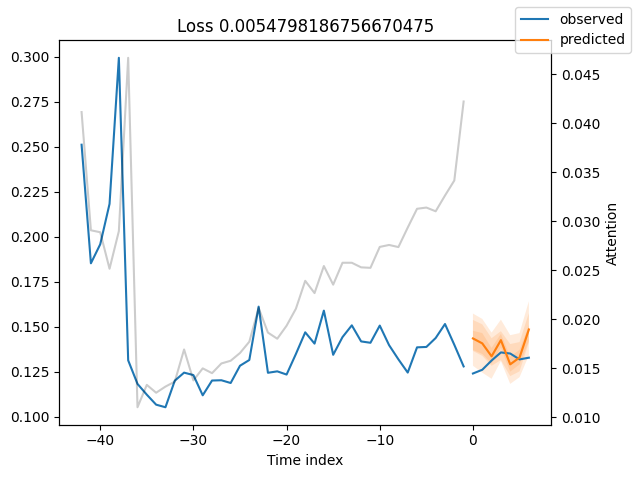

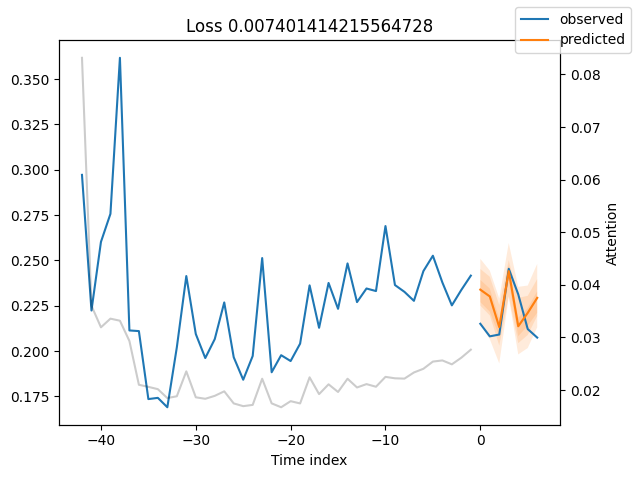

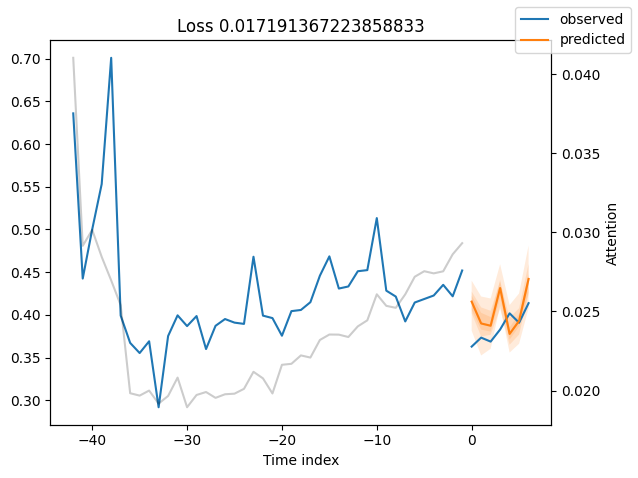

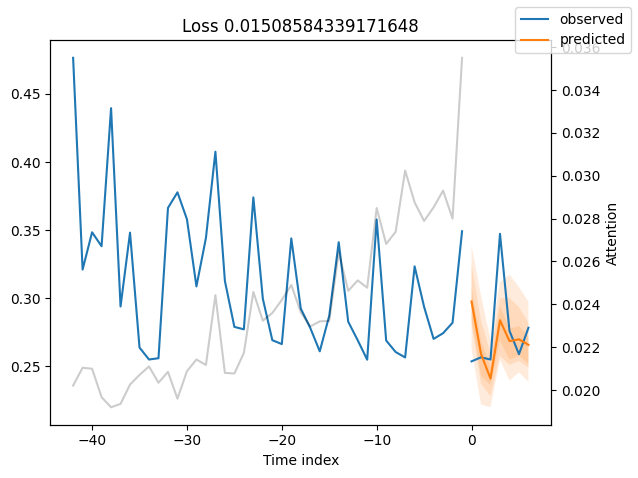

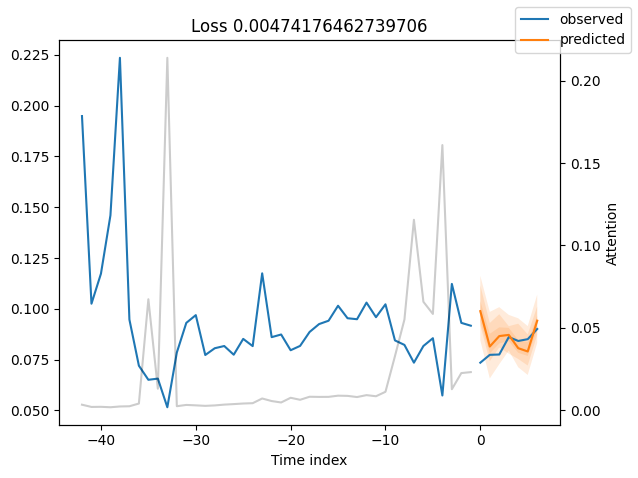

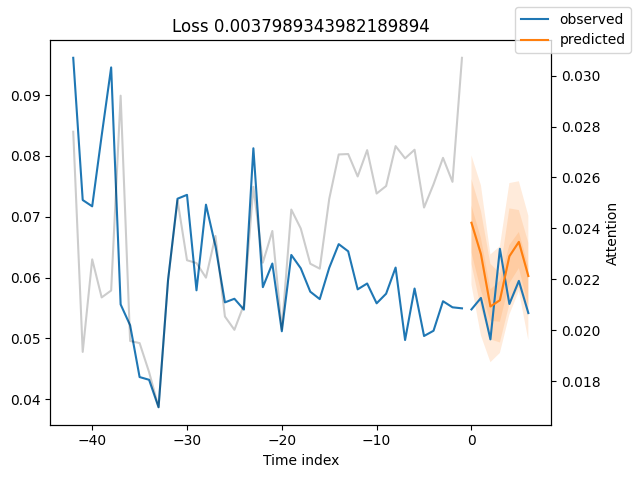

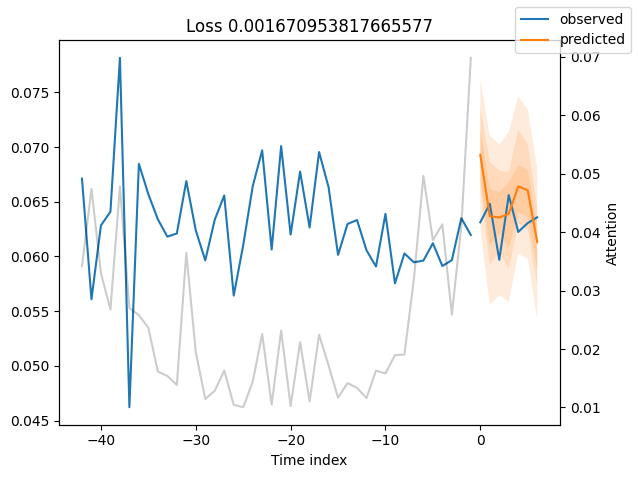

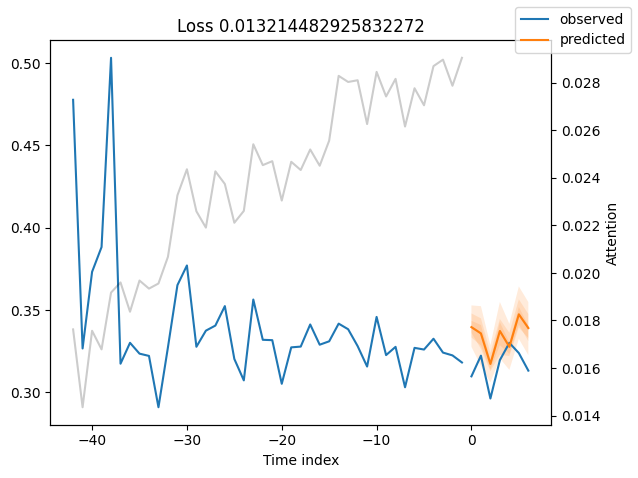

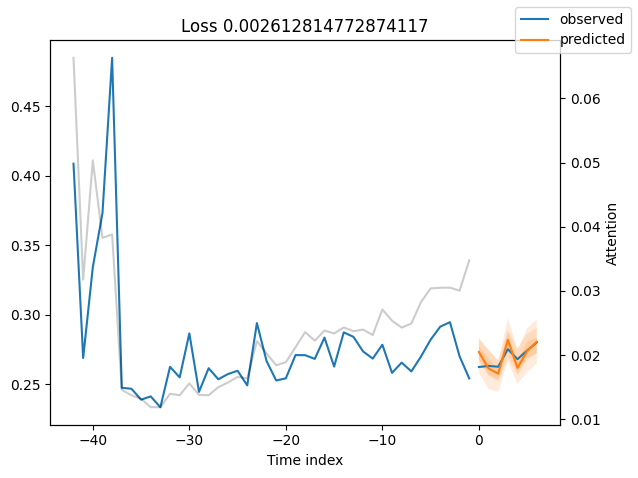

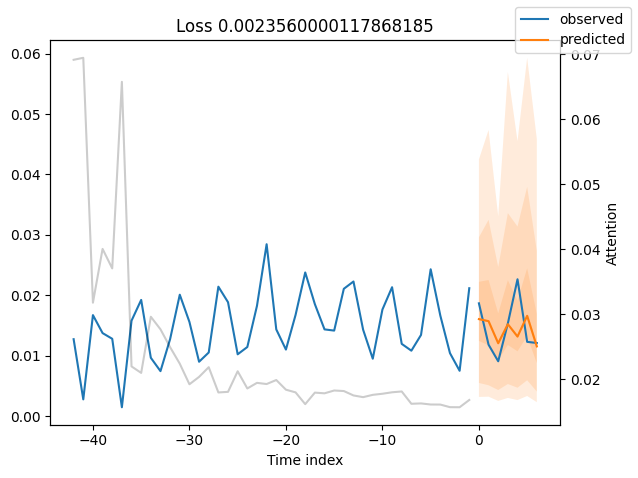

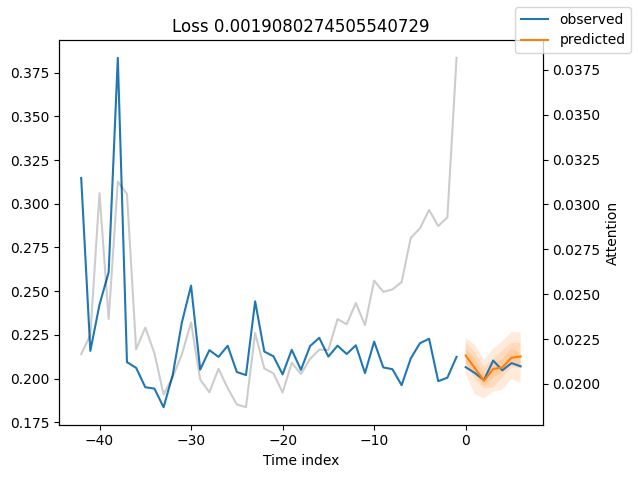

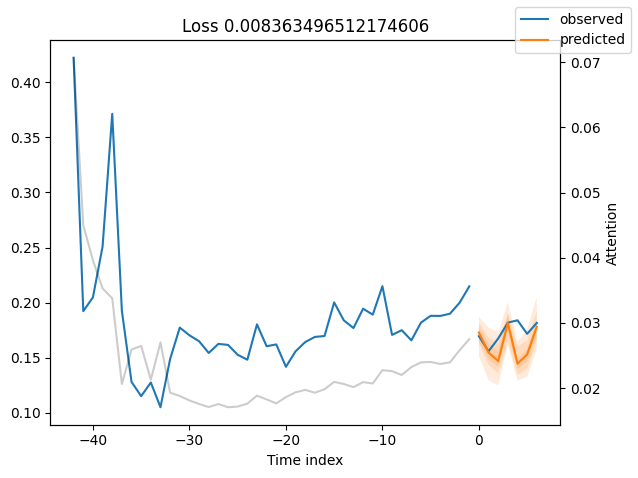

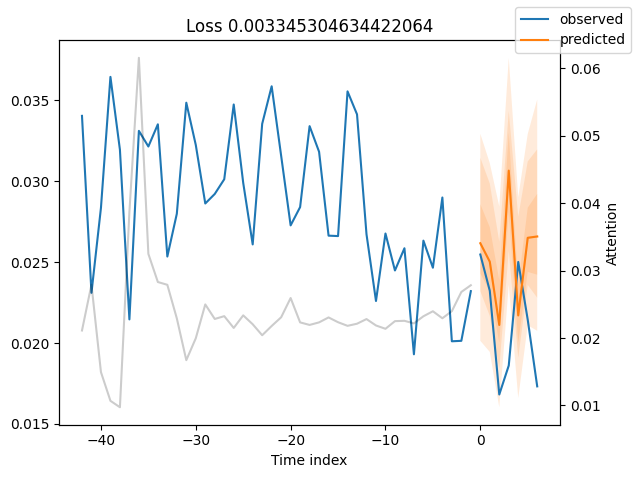

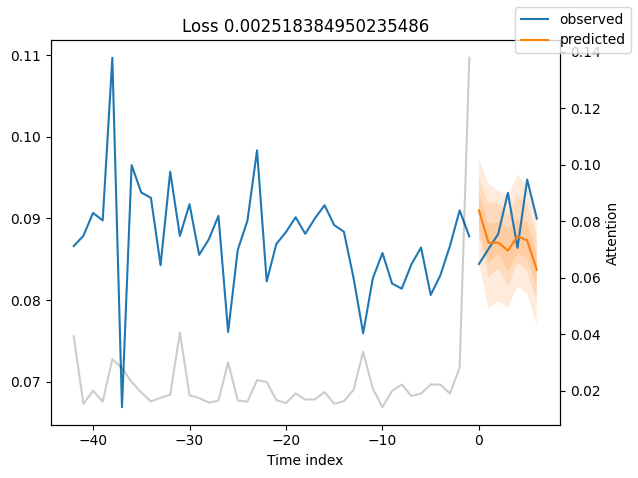

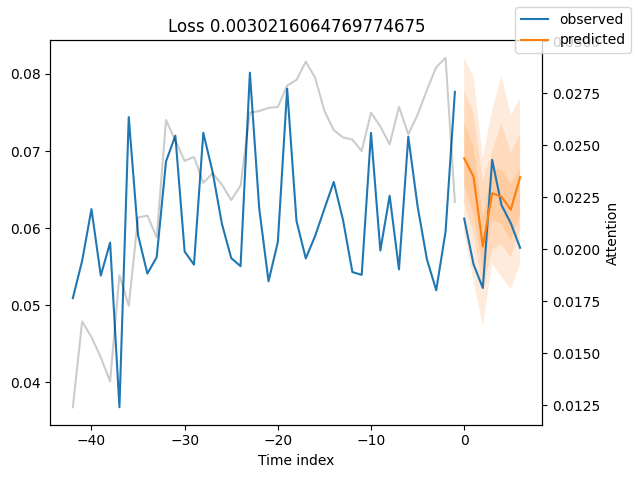

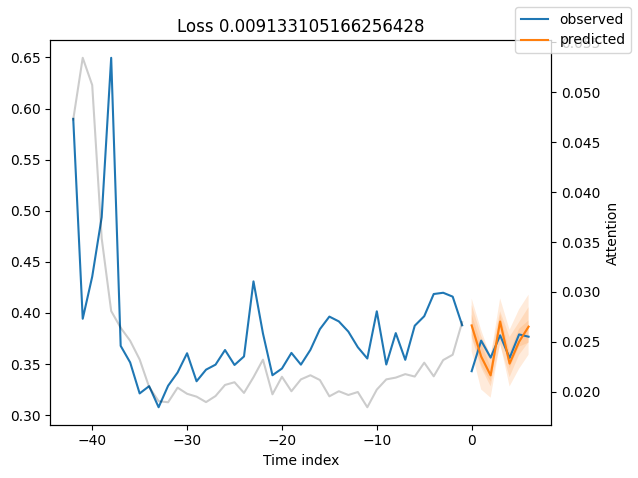

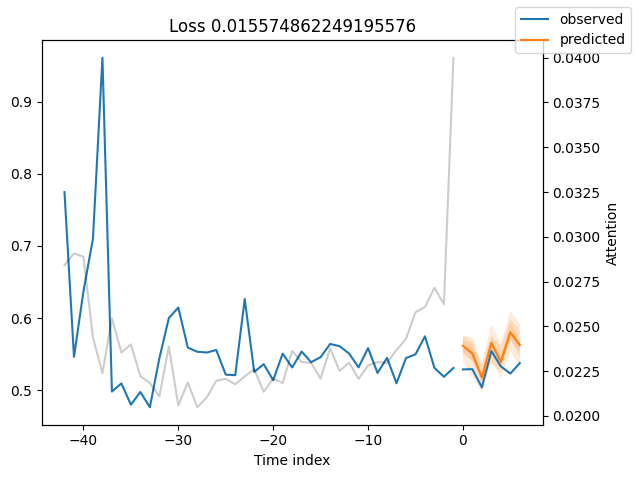

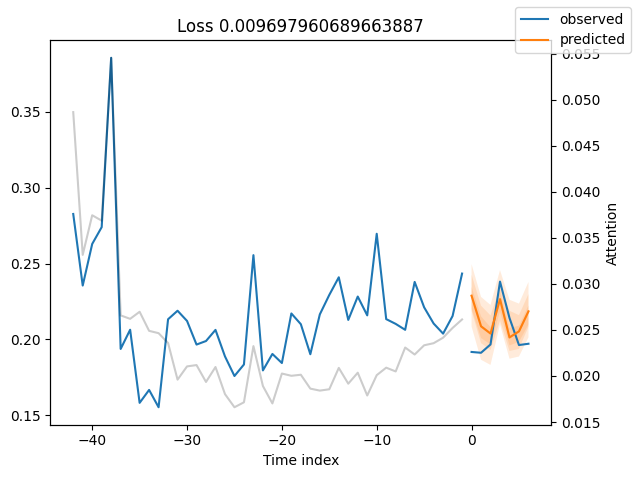

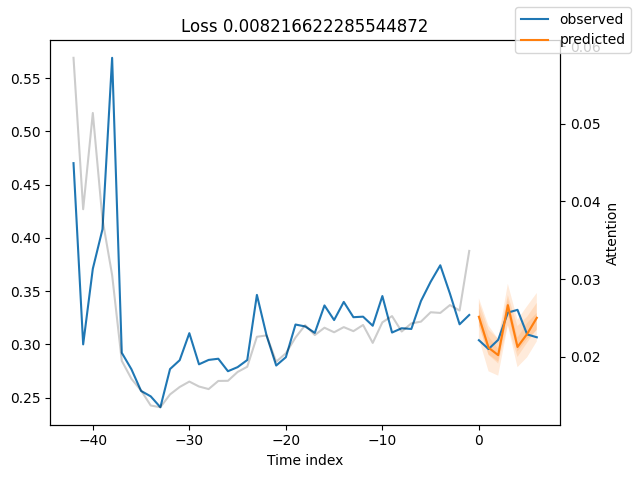

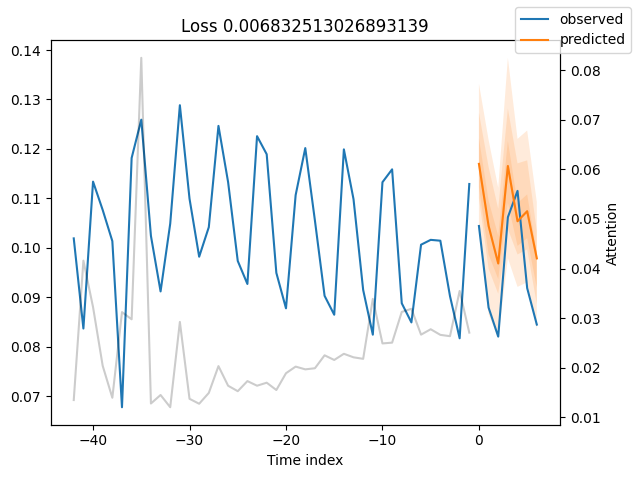

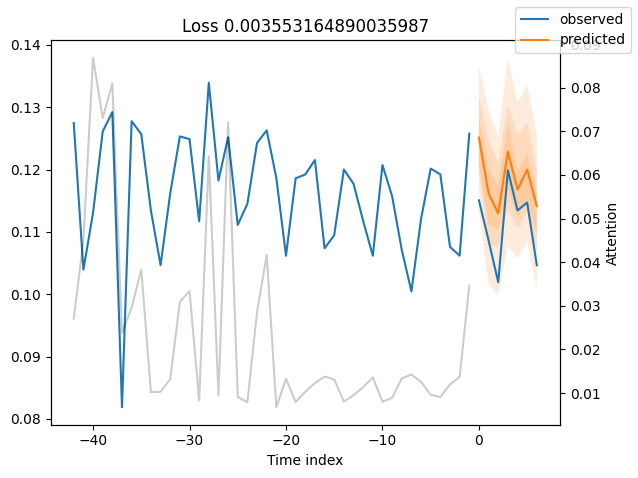

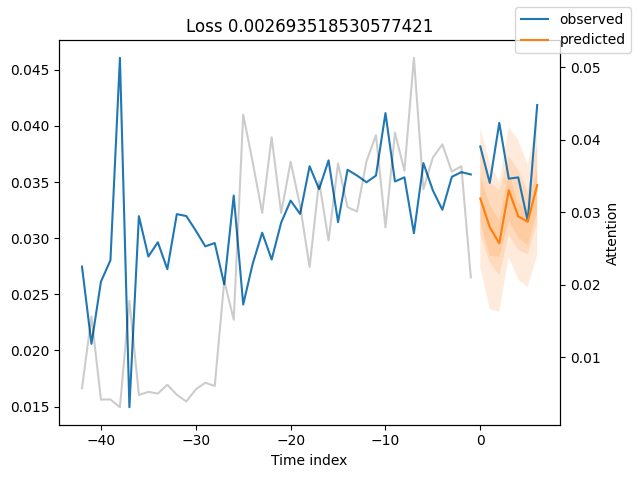

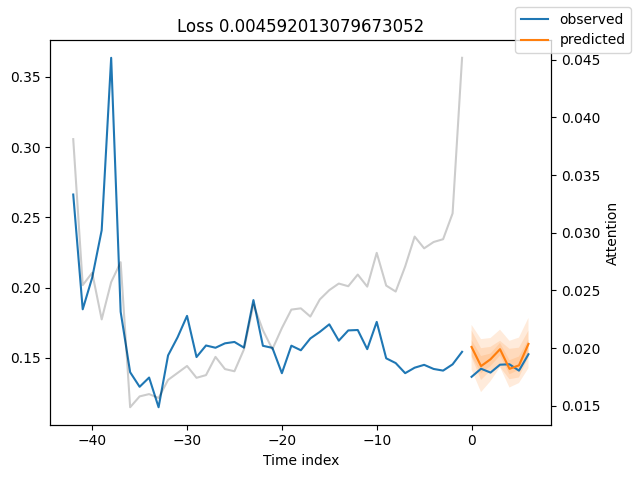

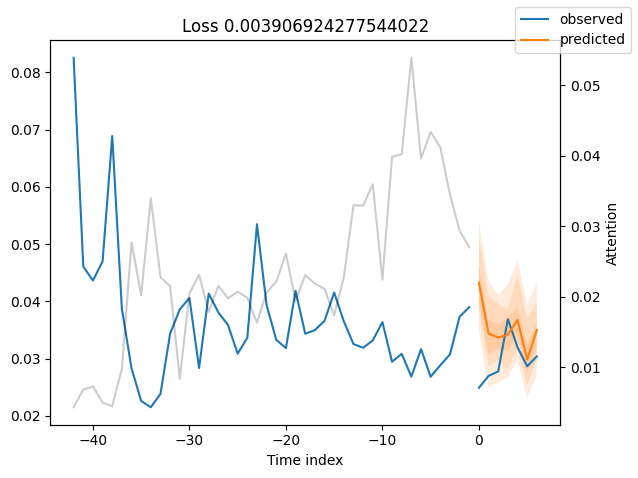

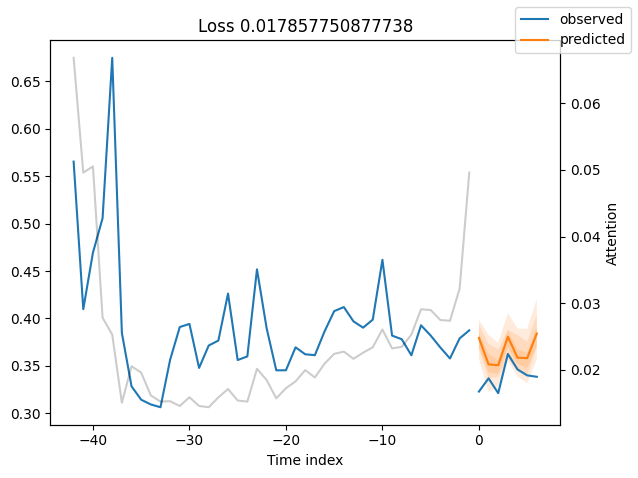

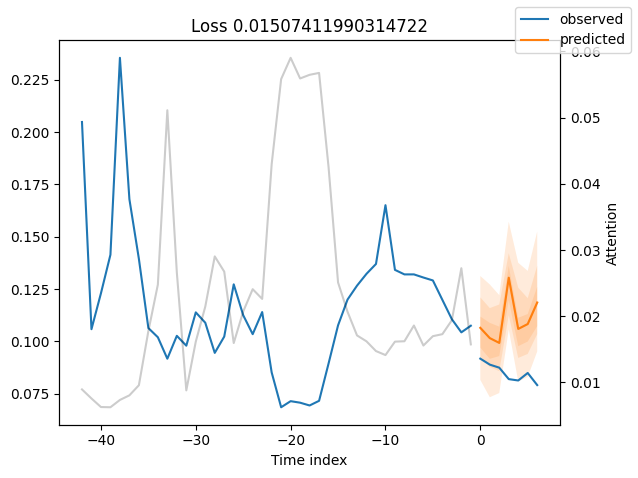

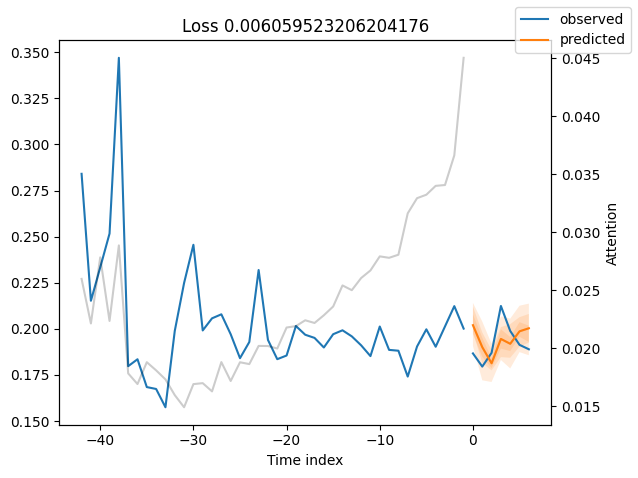

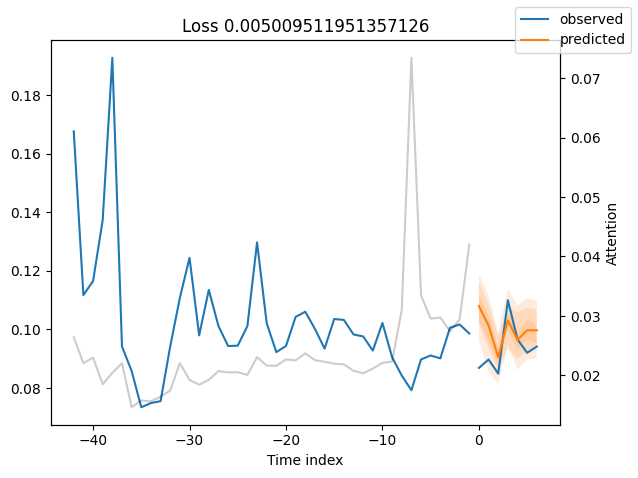

In [37]:
print(best_tft.predict(val_dataloader, mode="raw", return_x=True)._fields)

raw_predictions, x, idx, decoder_len, y = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(raw_predictions.prediction.shape[0]):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [38]:
#Take a look at what the raw_predictions variable contains
print(raw_predictions._fields)
print('\n')
#Get 10 weeks prediction of 45 stores with 7 quantiles
print(raw_predictions['prediction'].shape)

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([45, 7, 7])


## Evaluate on a specific Time-Series

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


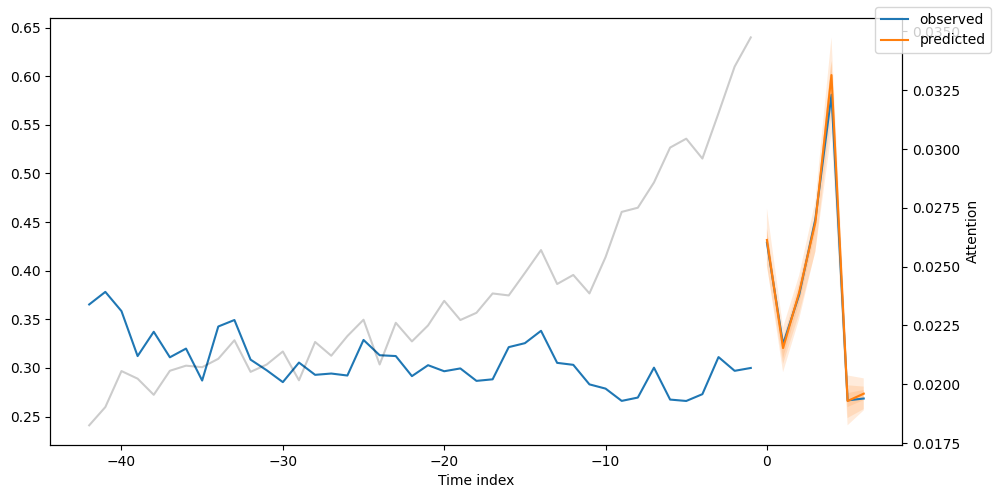

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

raw_predictions, x, index, decoder_len, y  = best_tft.predict(
    training.filter(lambda x: (x.Store == "11")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_predictions, idx=0, ax=ax);

## Feature Importances

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x350 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

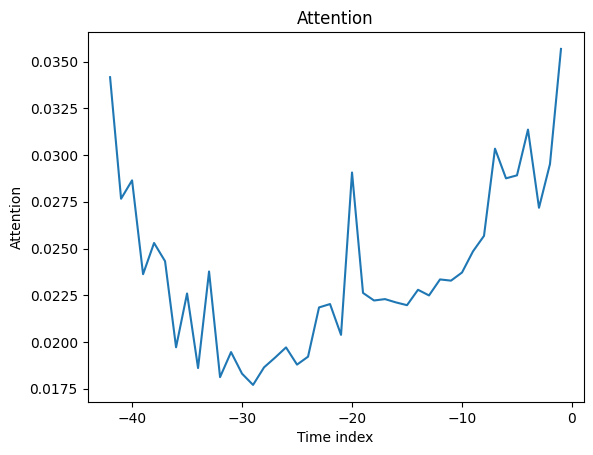

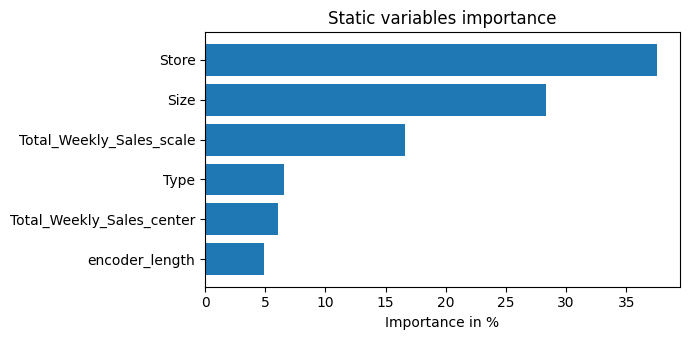

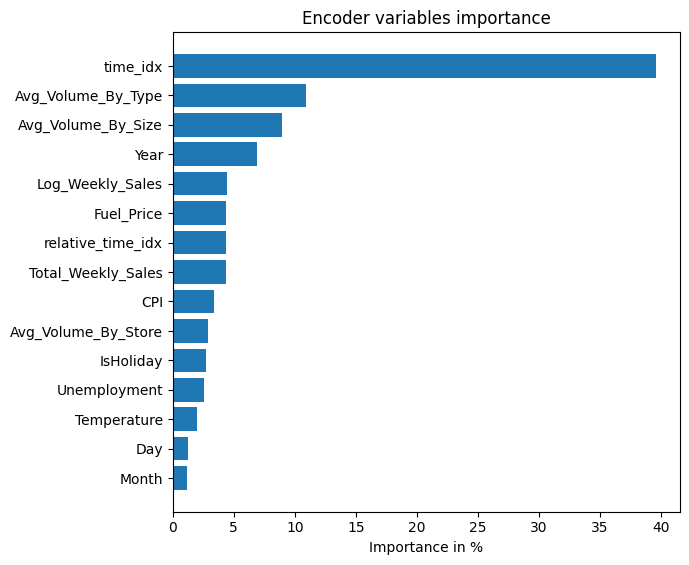

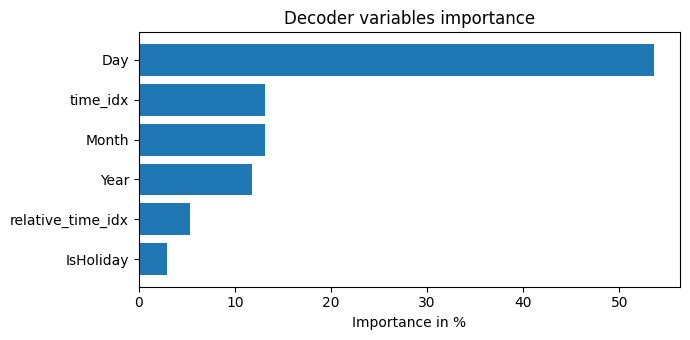

In [40]:
raw_predictions, x, index, decoder_len, y = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Extreme Event Detection

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:1864: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

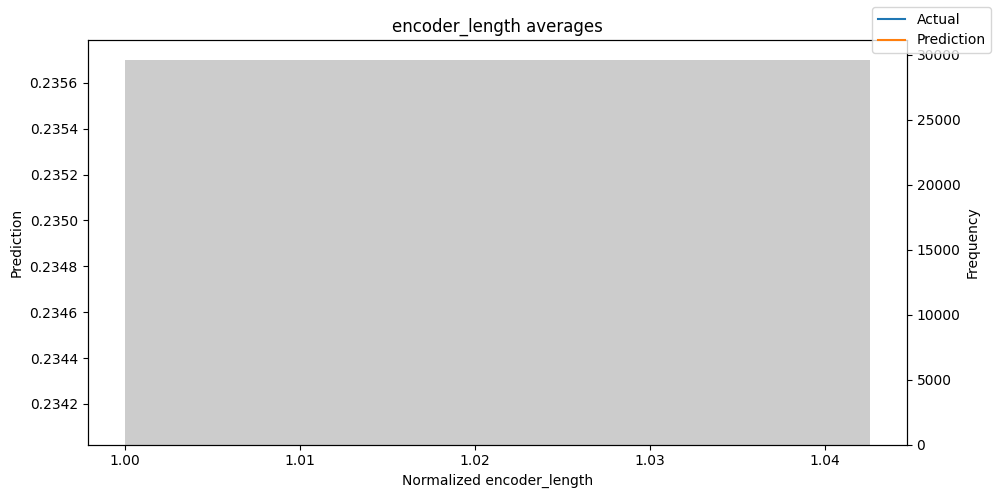

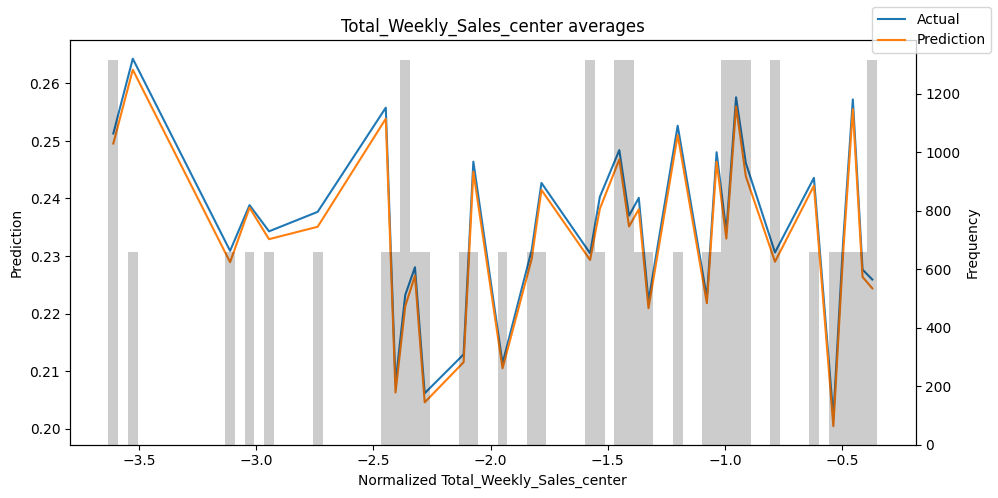

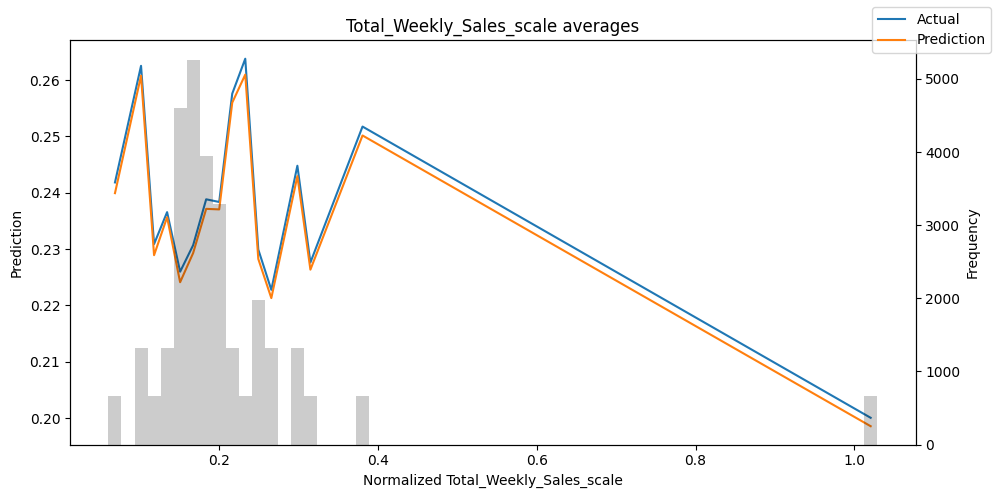

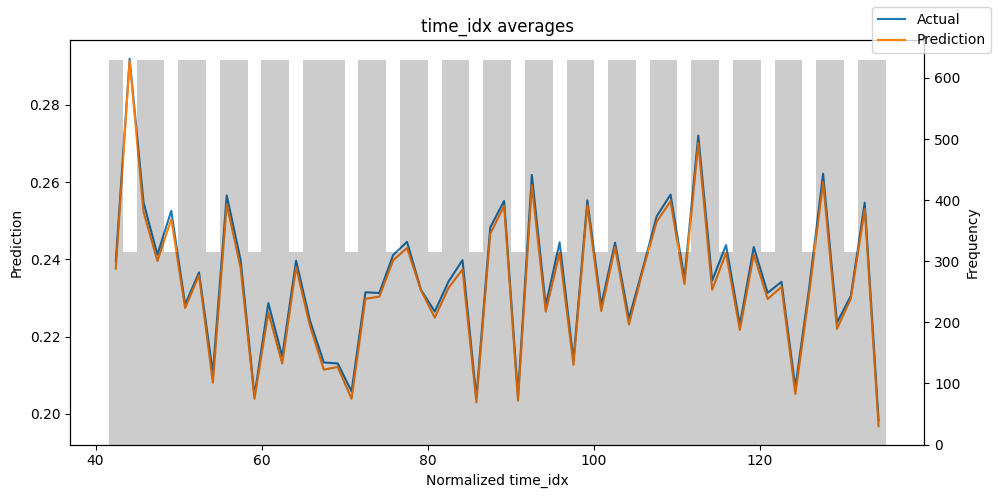

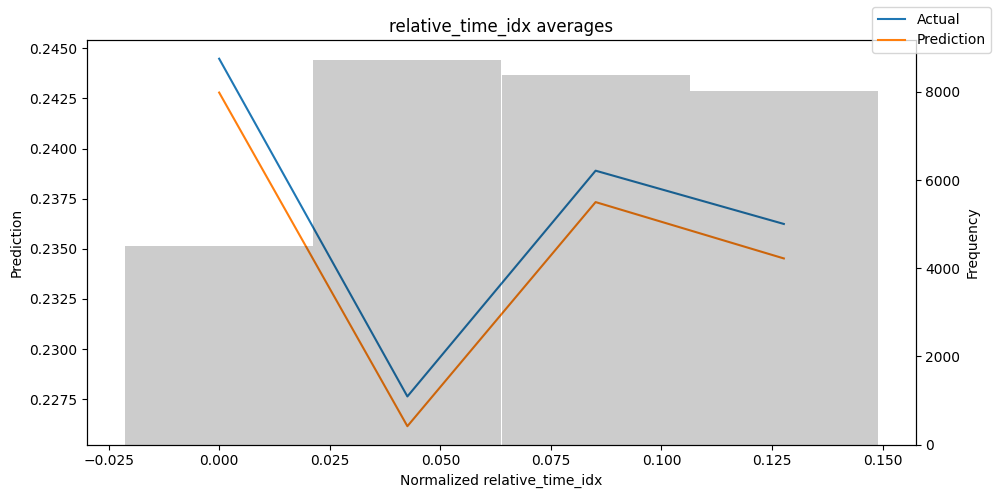

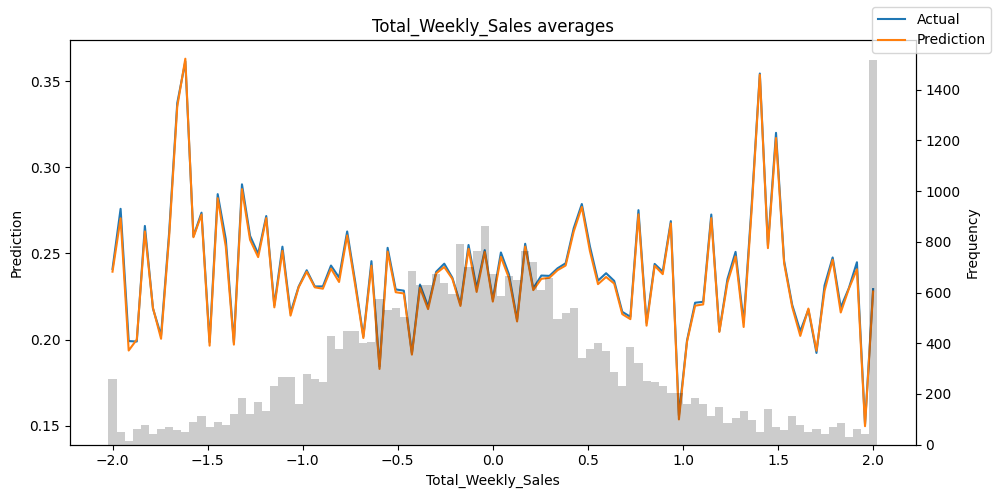

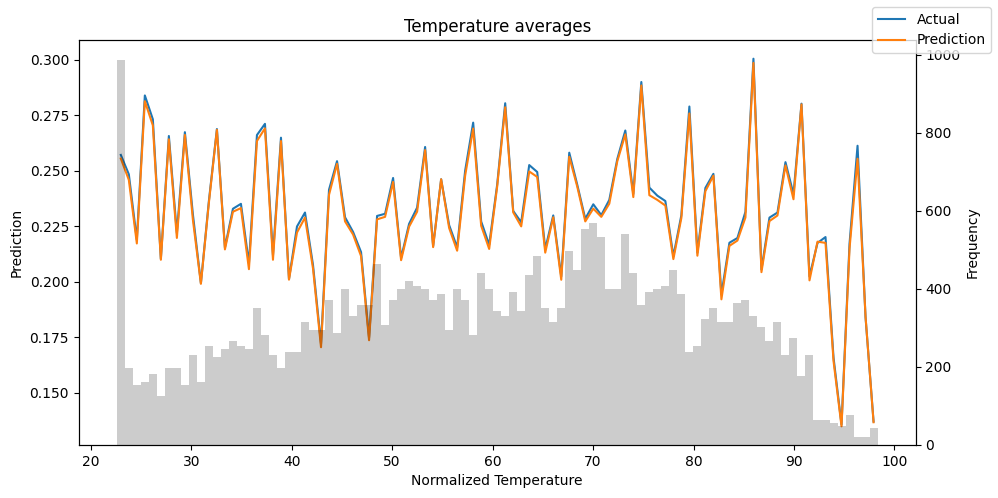

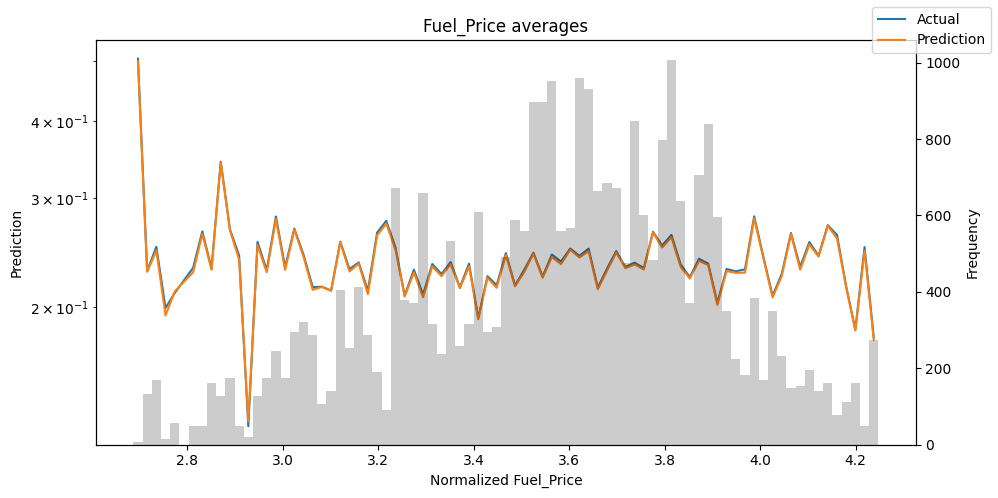

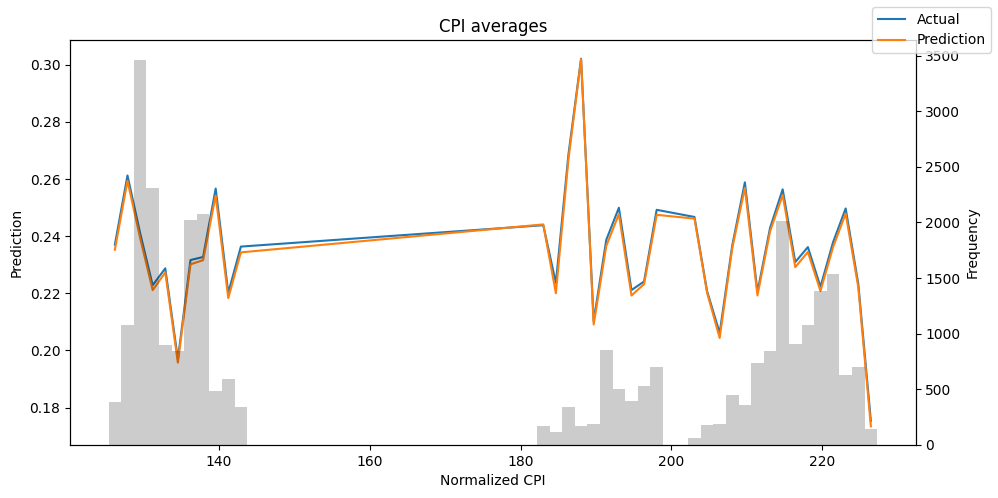

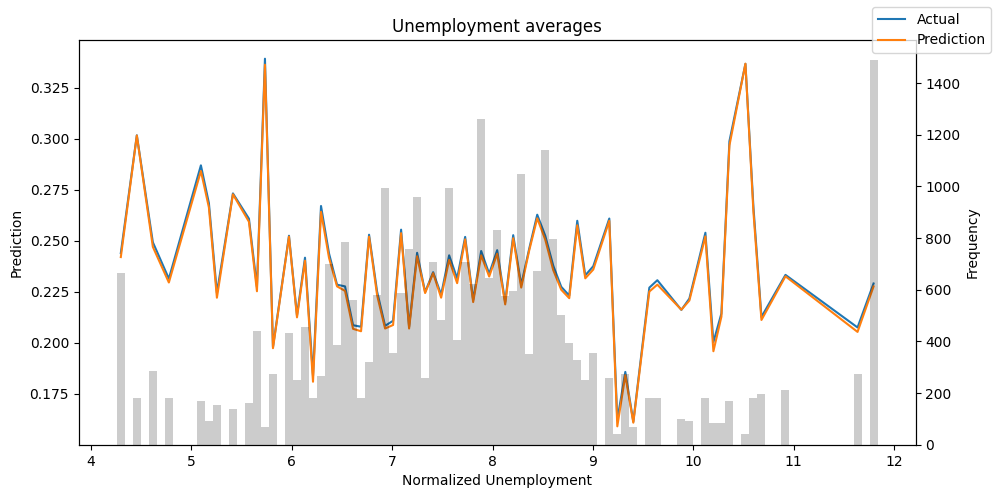

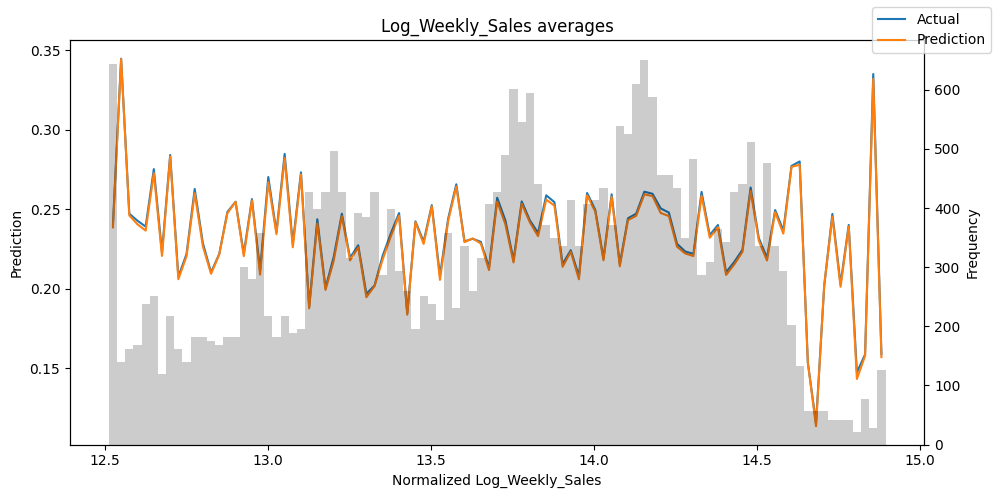

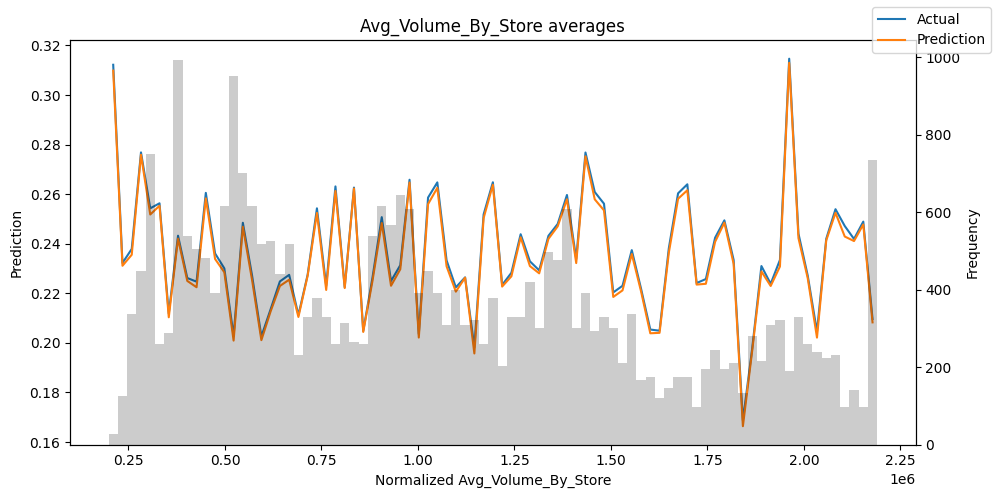

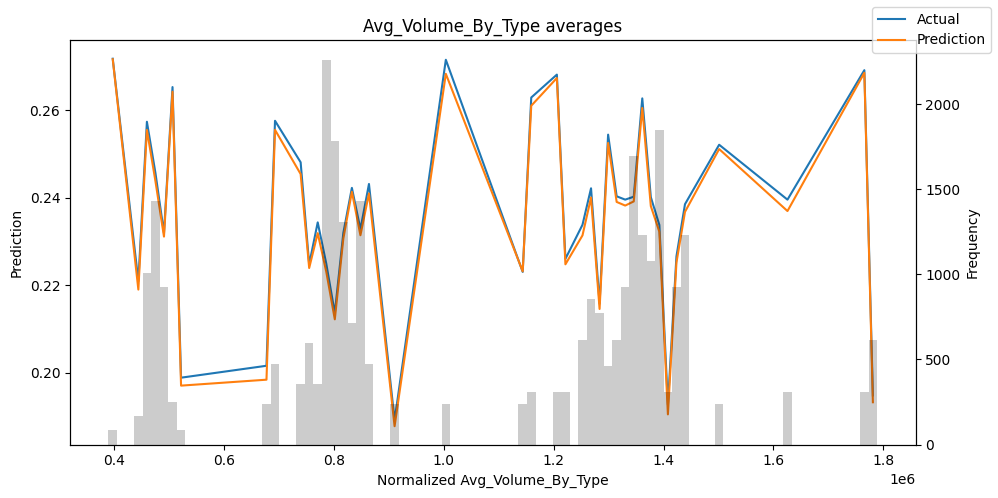

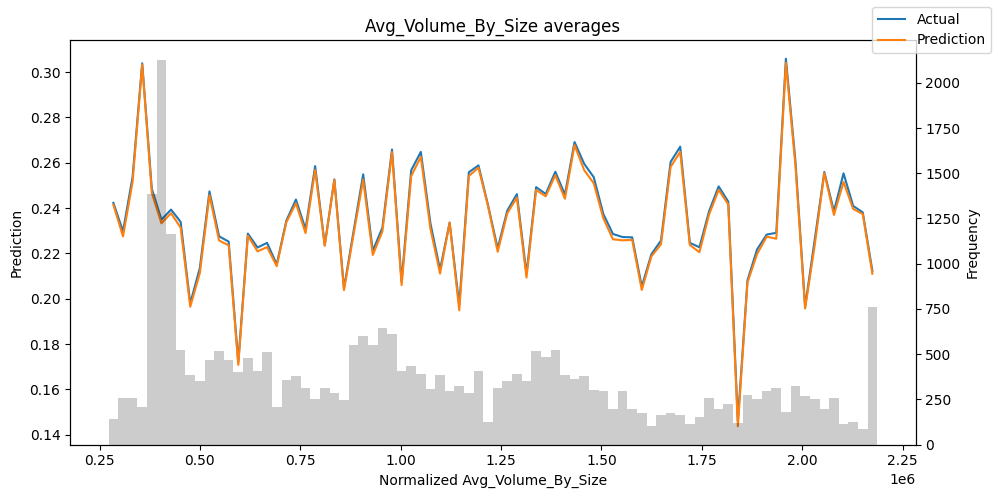

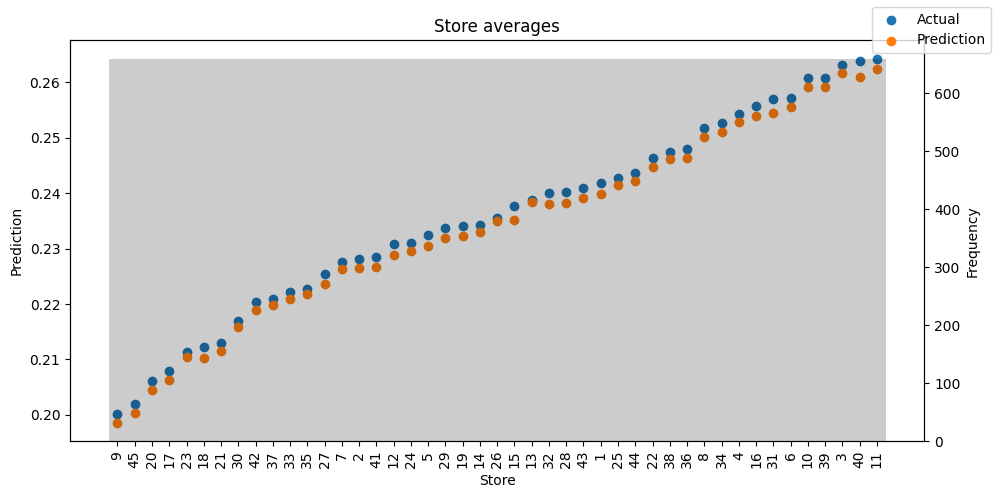

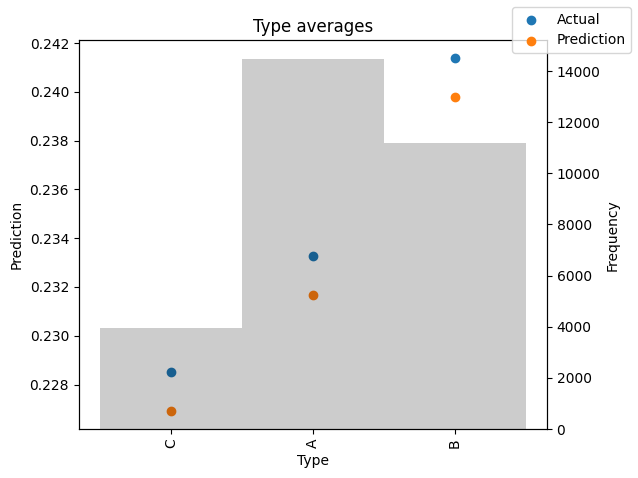

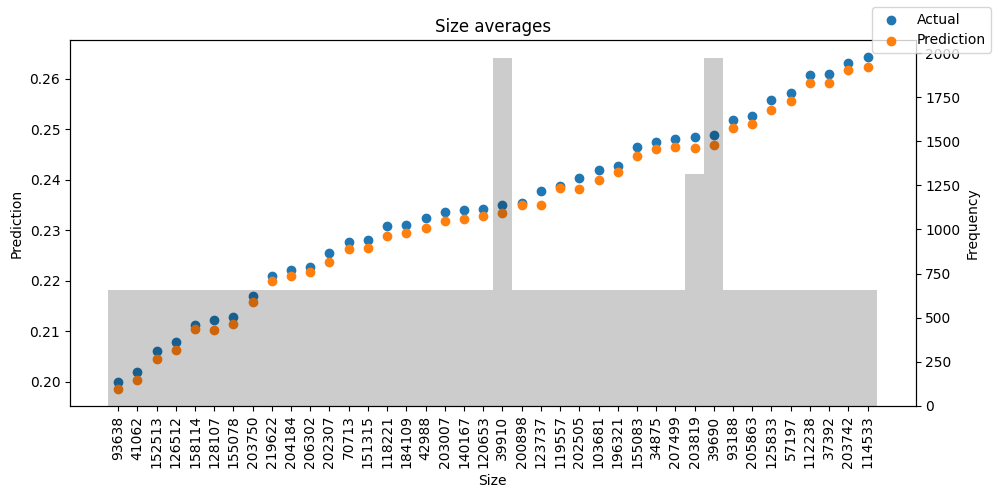

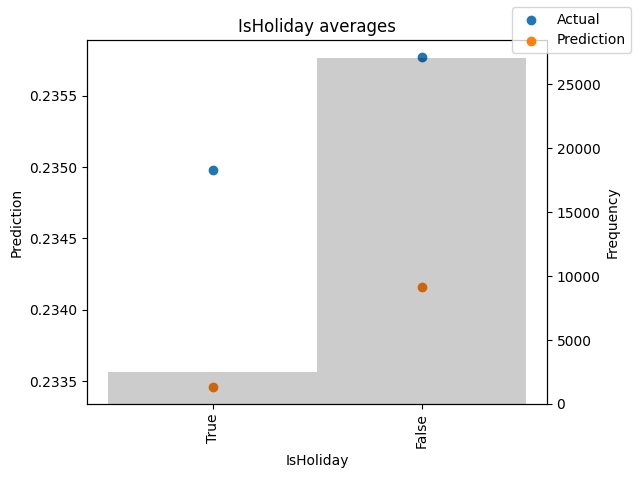

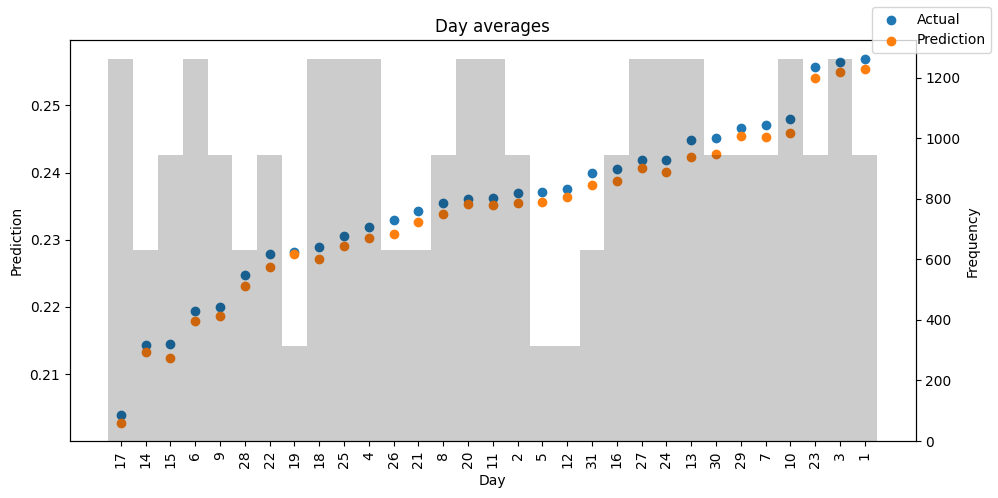

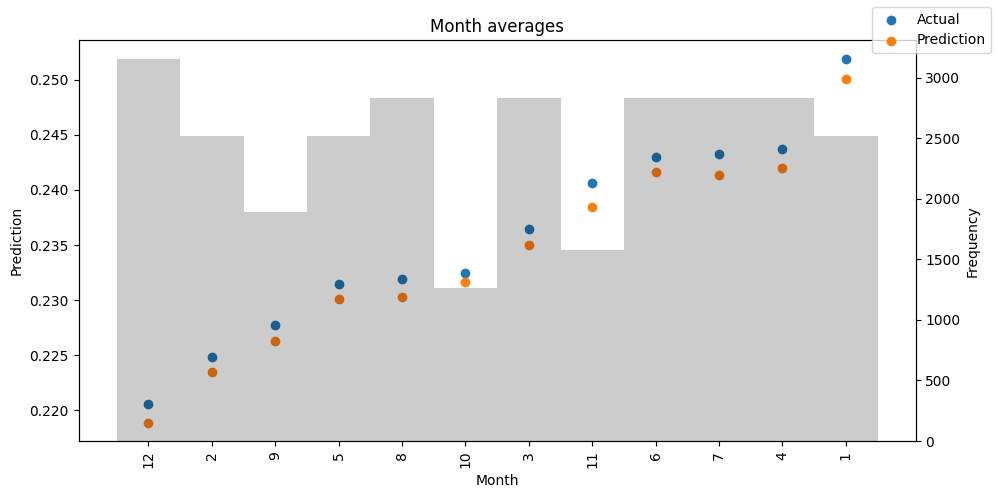

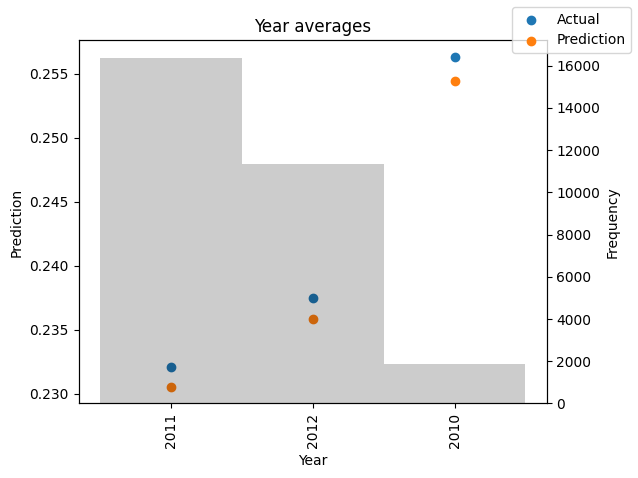

In [41]:
#Analysis on the training set
predictions, x, index, decoder_len, y = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\Weihau.yap\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calcu

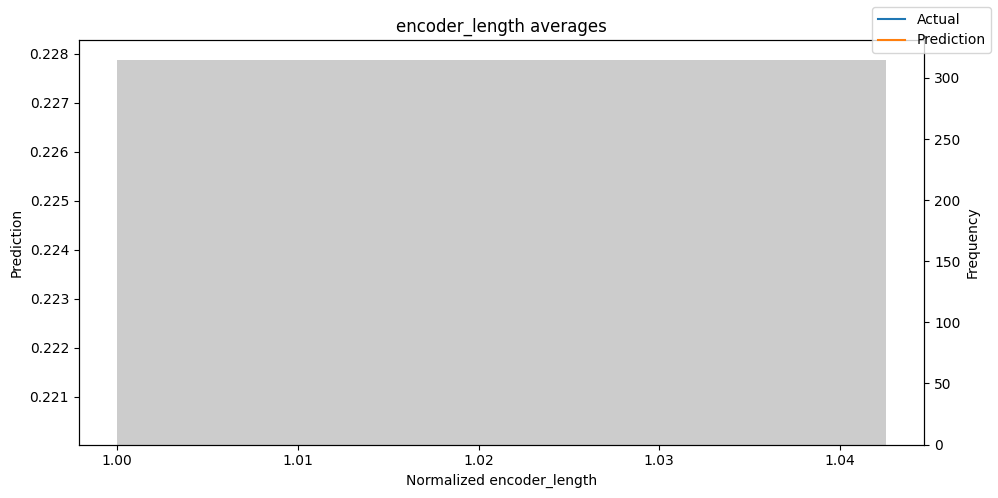

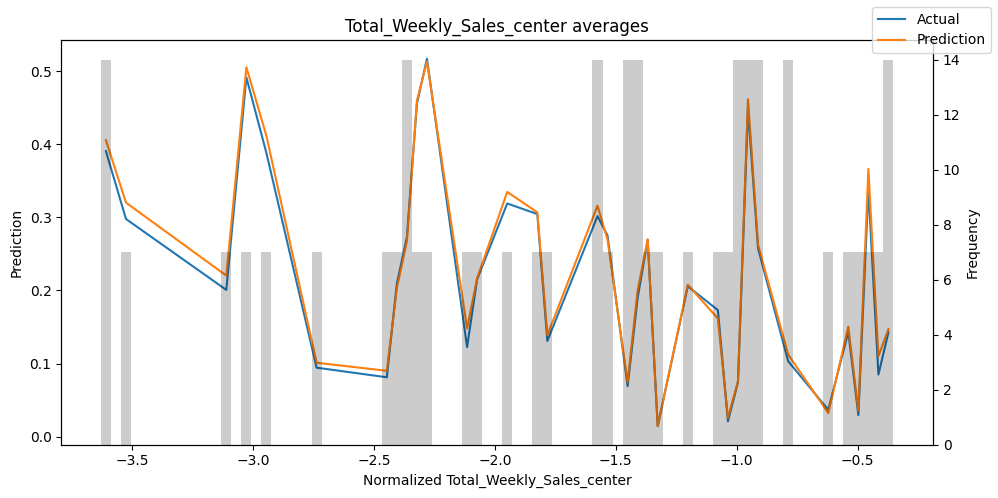

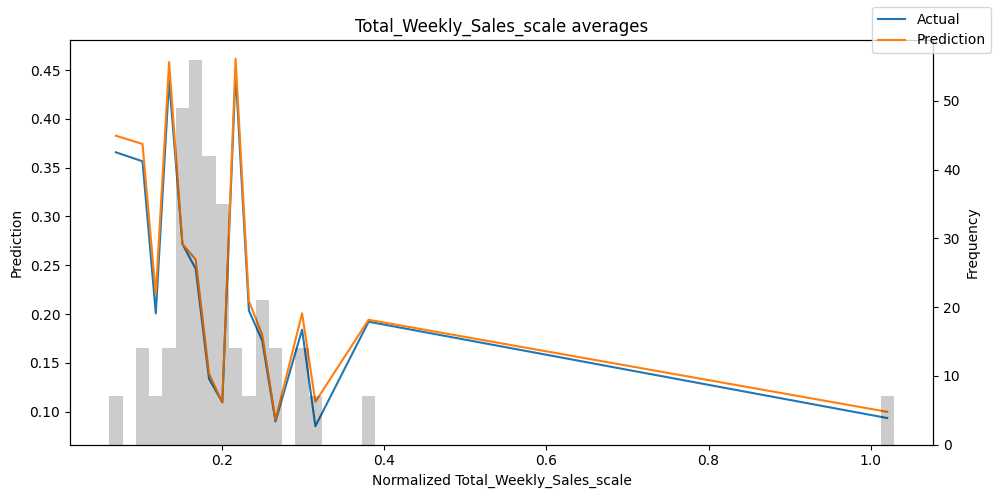

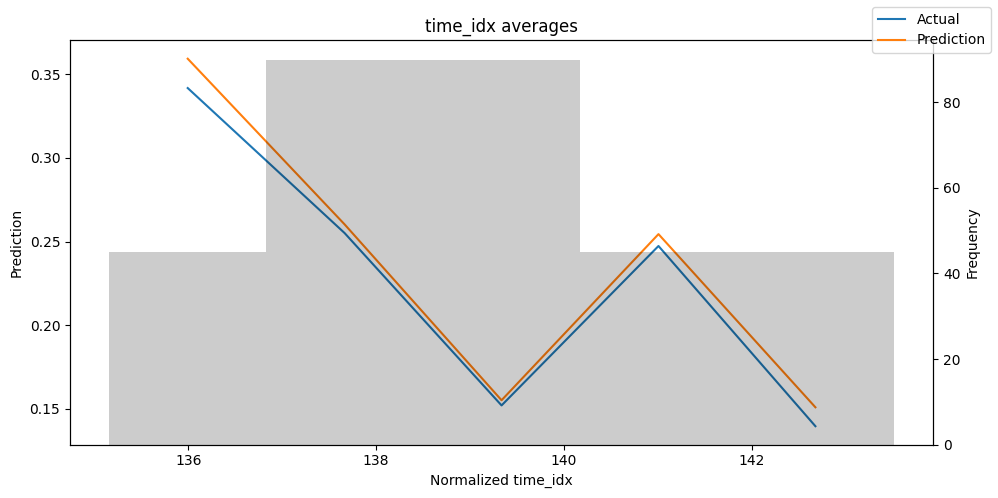

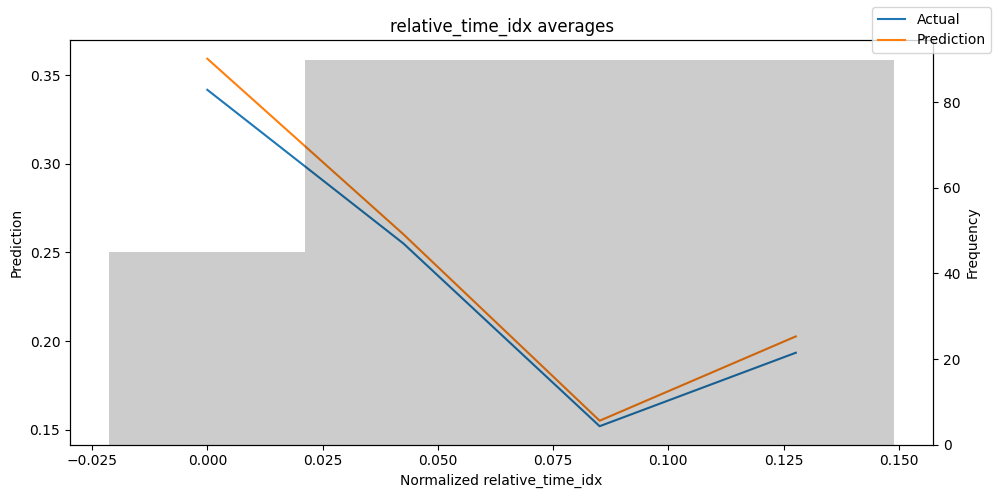

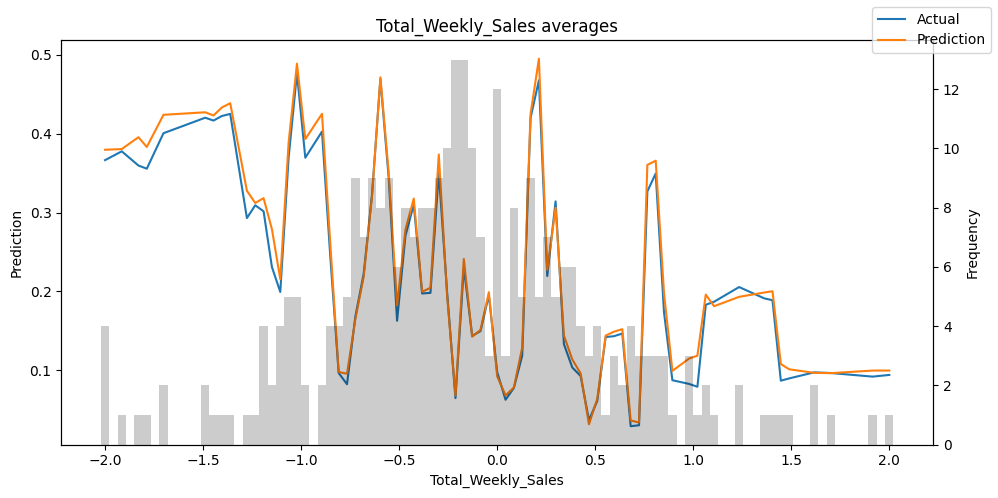

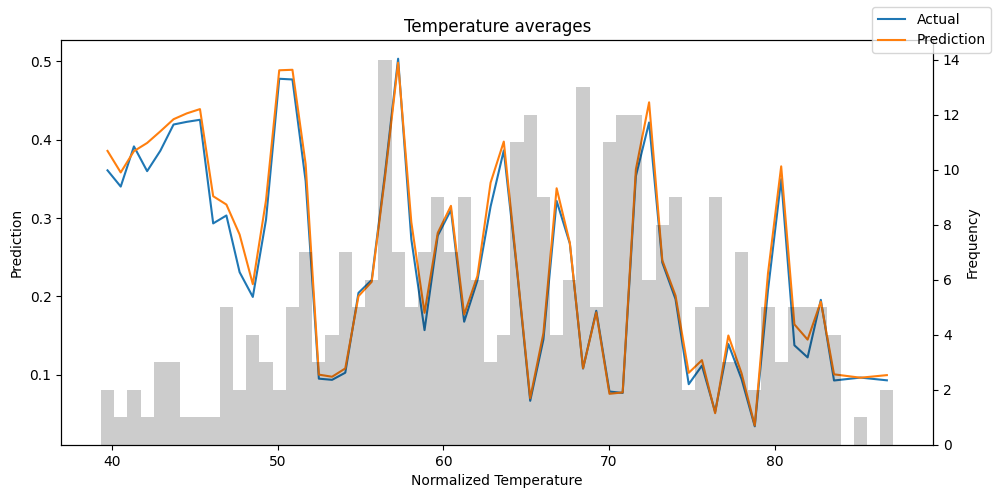

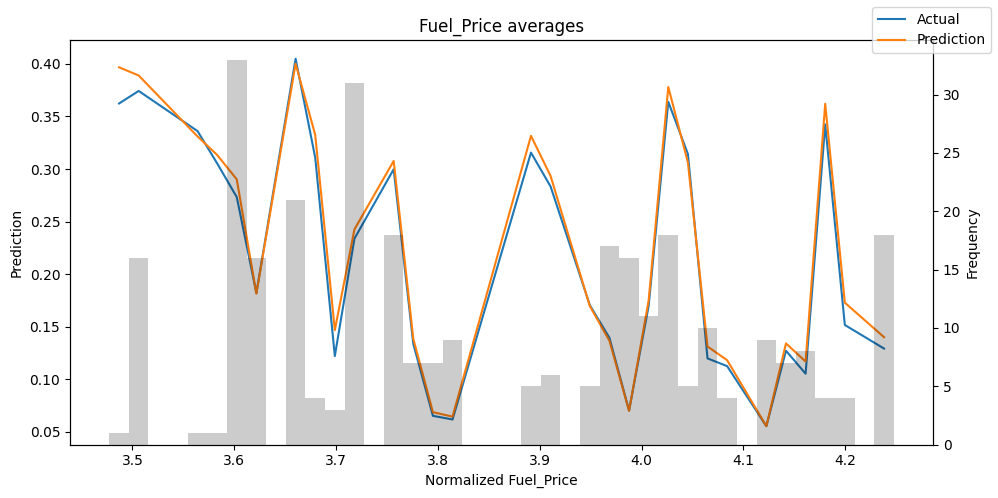

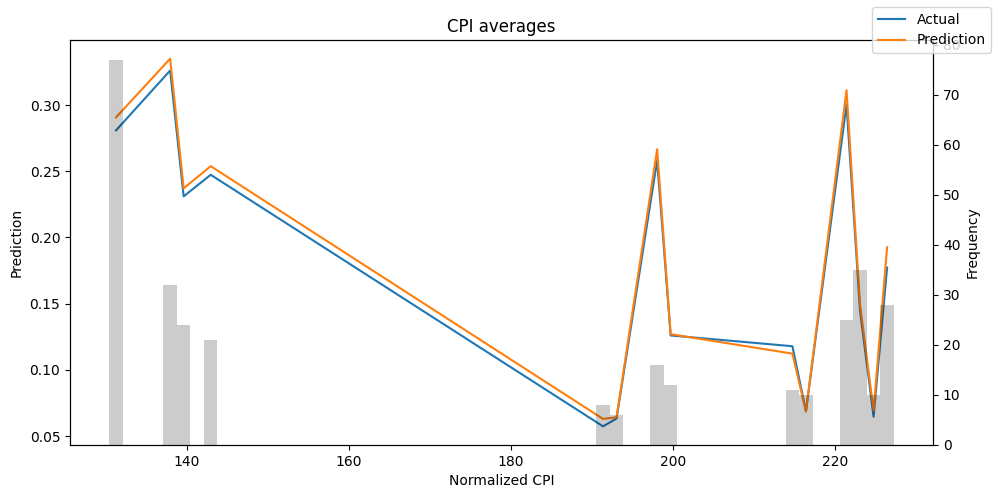

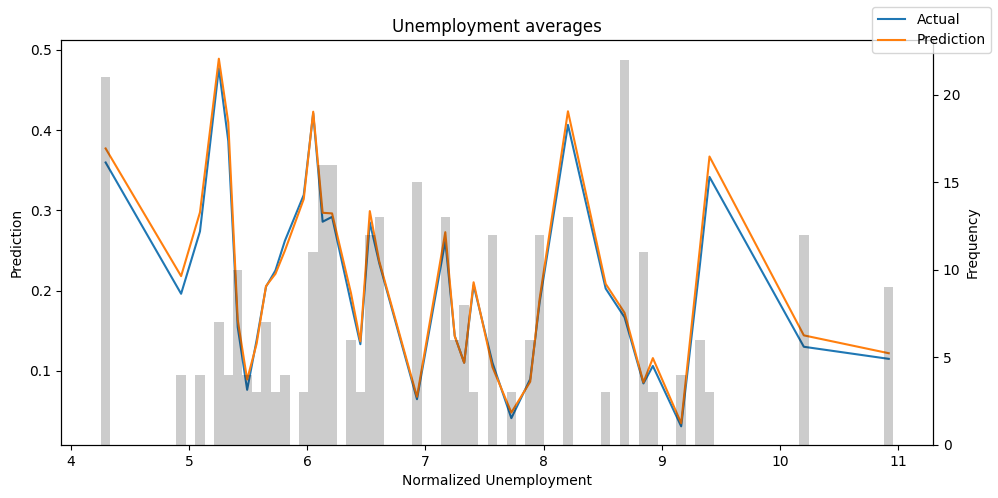

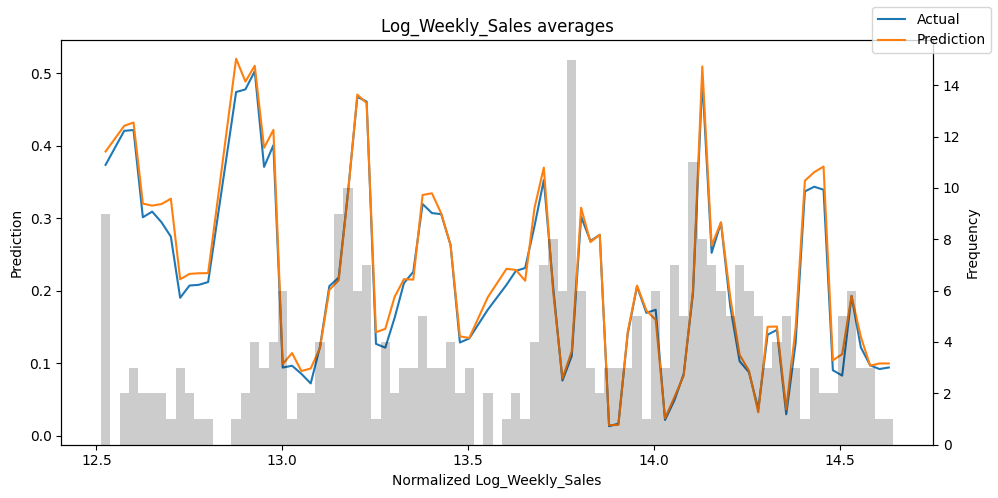

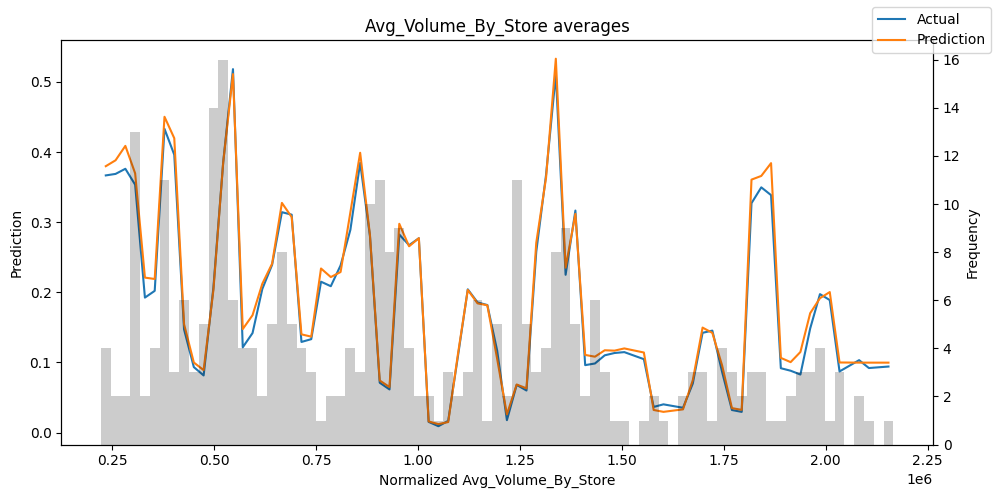

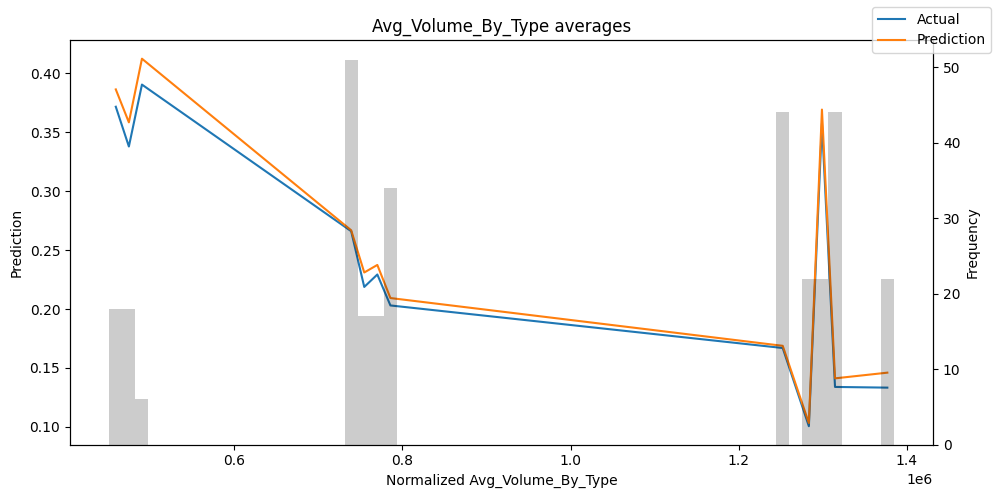

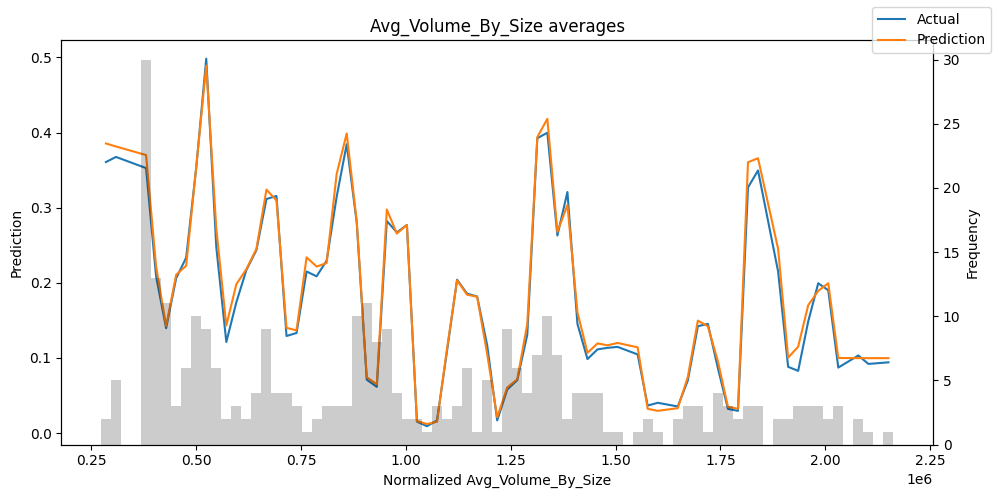

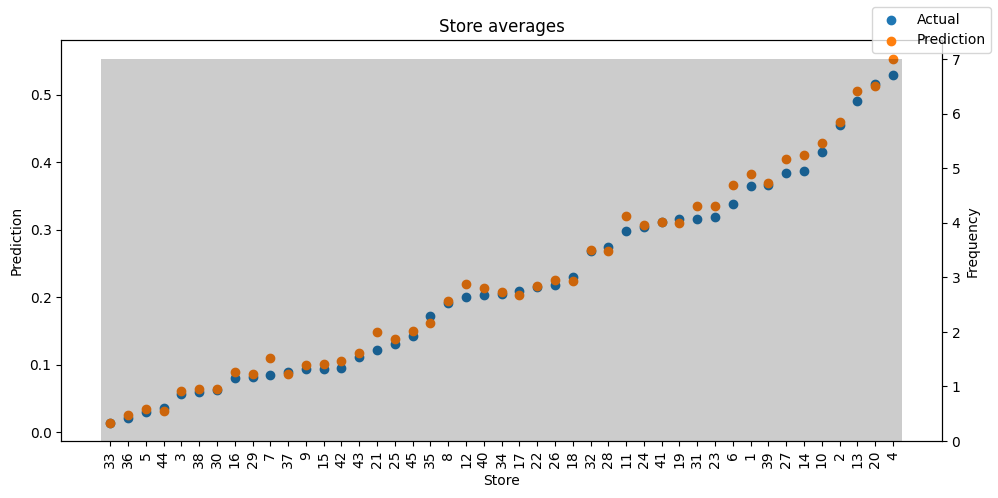

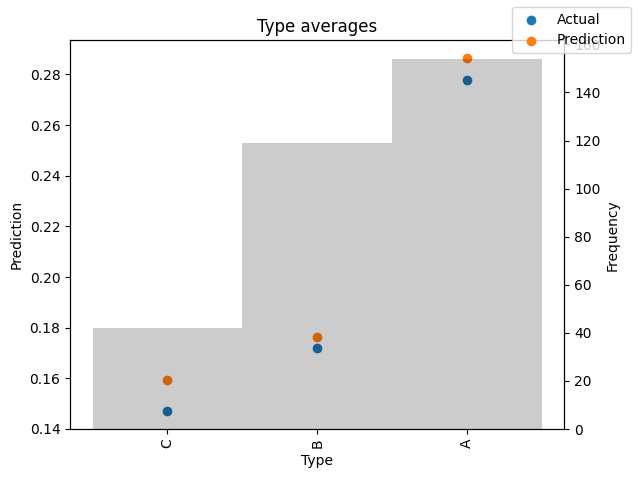

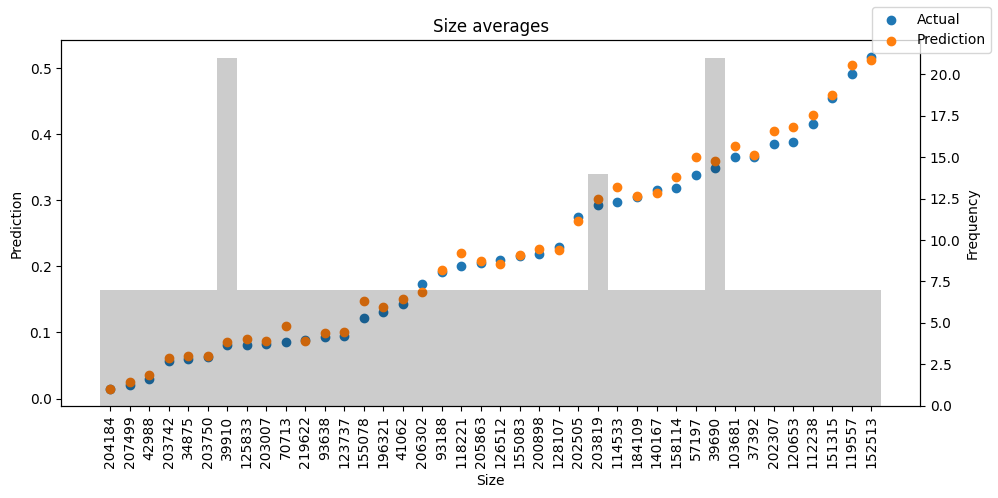

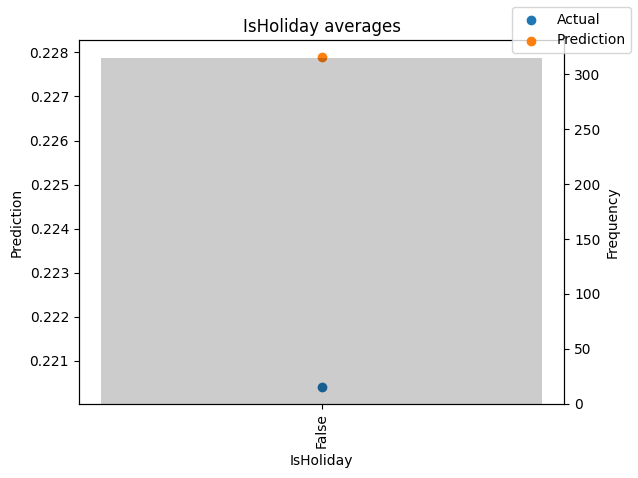

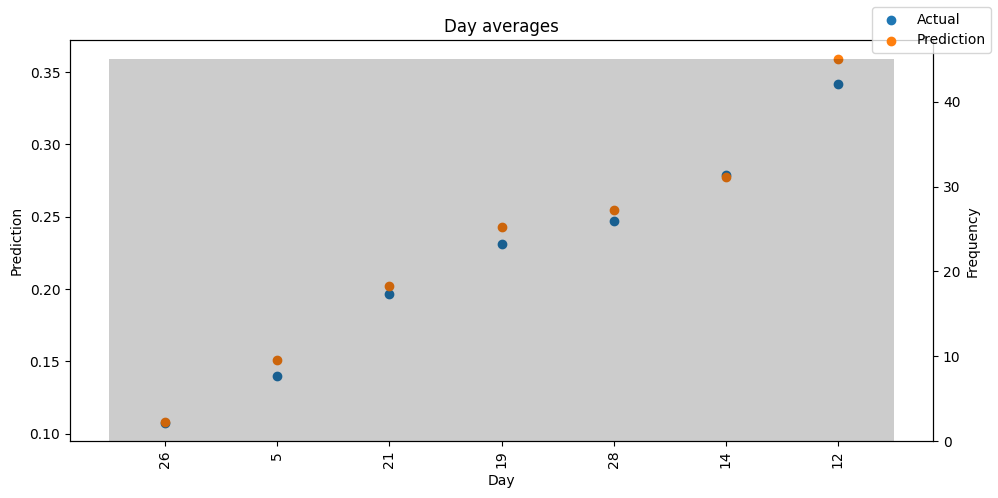

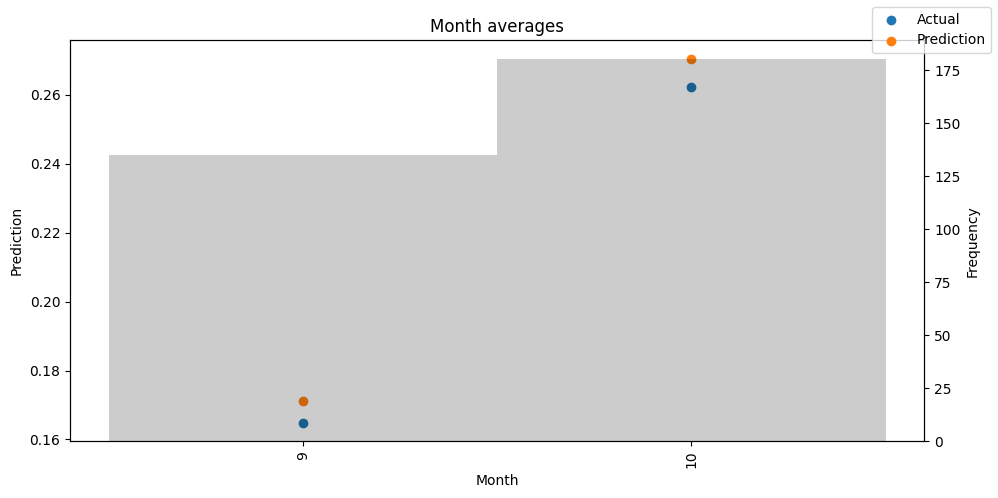

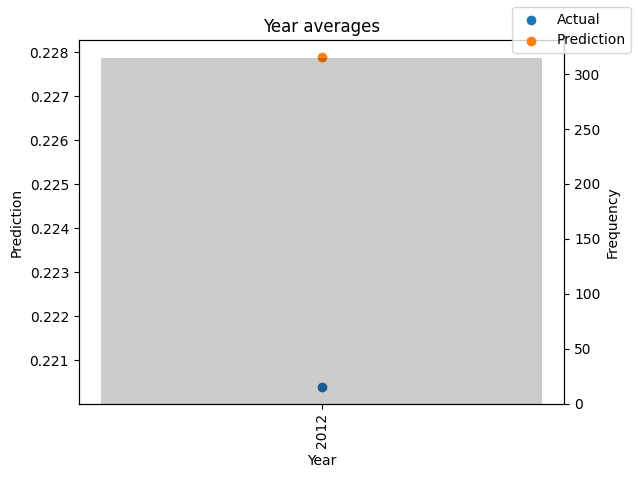

In [42]:
predictions, x, index, decoder_len, y = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);